<a href="https://colab.research.google.com/github/LeopoldGmelin/Projects/blob/main/SimulationsandLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Elspotprices.csv to Elspotprices.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving temperatur_dk_2017_2022.csv to temperatur_dk_2017_2022.csv


/tmp/ipython-input-7-2860547723.py:38: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch     1: Train-MSE=5.487332 | Val-MSE=4.721711
Epoch  1001: Train-MSE=0.005139 | Val-MSE=0.010655
Epoch  2001: Train-MSE=0.003797 | Val-MSE=0.008450
Epoch  3001: Train-MSE=0.003090 | Val-MSE=0.007491
Epoch  4001: Train-MSE=0.002633 | Val-MSE=0.007115
Epoch  5001: Train-MSE=0.002294 | Val-MSE=0.006963
Epoch  6001: Train-MSE=0.002039 | Val-MSE=0.006909
Epoch  7001: Train-MSE=0.001851 | Val-MSE=0.006859
Epoch  8001: Train-MSE=0.001700 | Val-MSE=0.006790
Epoch  9001: Train-MSE=0.001576 | Val-MSE=0.006722
Epoch 10000: Train-MSE=0.001470 | Val-MSE=0.006609
y_test scaled  min/max: 0.0 0.9977256607681646
y_pred_scaled min/max: -0.32175416678334495 0.6365754139567151
scaler_y min/max       : [0.] [255.020004]


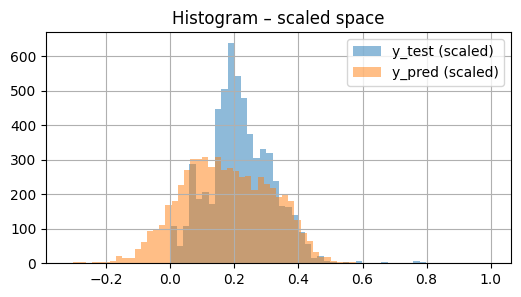

Baseline-MSE (Mittelwert): 685.78

--- Finale Metriken auf dem Test-Set (Originalmaßstab) ---
MSE (€/MWh): 1185.59
MAE (€/MWh): 27.71
R² (Originalmaßstab): -0.7288


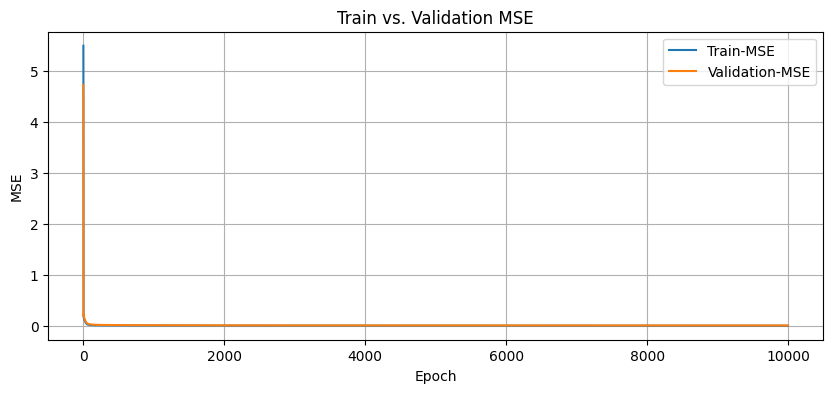

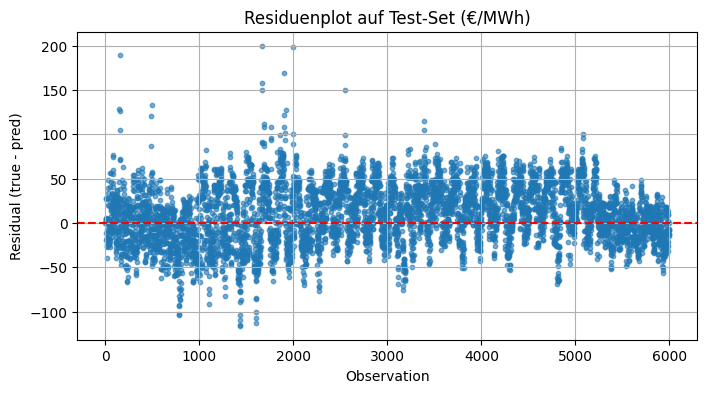

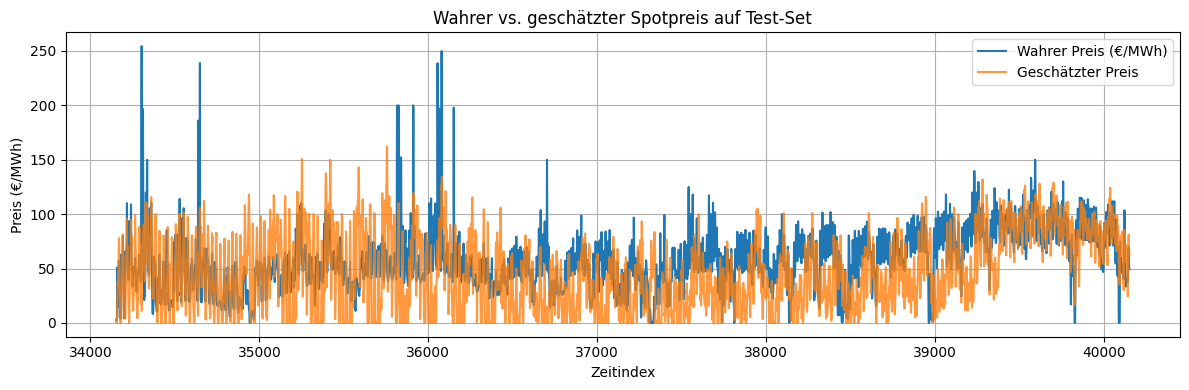

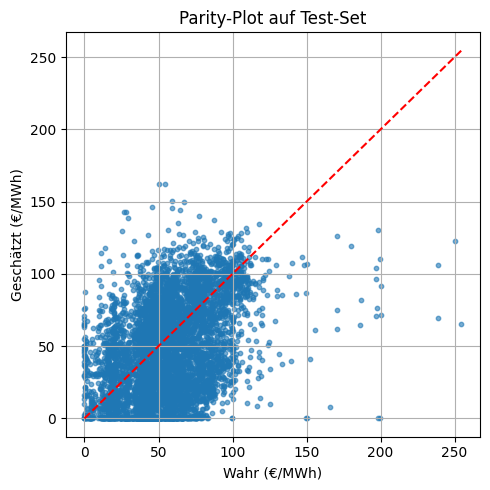

([array([[-0.16584875,  0.14454065, -0.32177228, ...,  0.16259906,
           0.07838335,  0.0201065 ],
         [ 0.22364255, -0.13500844, -0.05573275, ..., -0.1713748 ,
          -0.03824204,  0.21189146],
         [-0.03798553, -0.10750132,  0.8537695 , ..., -0.37842738,
           1.01964578,  0.1333279 ],
         ...,
         [-0.23566064,  0.41266641, -0.51781425, ...,  0.14776728,
          -0.20527276,  0.48958569],
         [ 0.12728296, -0.60351636,  0.01484582, ...,  0.35472161,
           0.08334295, -0.21996454],
         [-0.02295816, -0.28678912, -0.17589212, ...,  0.11729045,
          -0.39689887, -0.36788595]]),
  array([[ 0.02855043,  0.04039118,  0.06098627, ..., -0.04844884,
          -0.00372953, -0.0359651 ],
         [ 0.05735864,  0.00545528, -0.00839969, ...,  0.0772611 ,
           0.10878248, -0.01468525],
         [-0.0191686 , -0.00187312, -0.09718384, ..., -0.18883353,
           0.00469431, -0.01478255],
         ...,
         [-0.02984555, -0.05402445

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from IPython.display import IFrame
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
import joblib

# ---------------------------------------------------------------------------
# DATENLADEN UND GRUNDLEGENDES PREPROCESSING (weitgehend unverändert)
# ---------------------------------------------------------------------------

# Pfad anpassen, falls notwendig
# src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
# if src_path not in sys.path:
#     sys.path.append(src_path)

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.sort_values("HourUTC")
df = df.set_index("HourUTC")

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df.columns = temp_df.columns.str.strip()
temp_df["time"] = pd.to_datetime(temp_df["time"])
temp_df = temp_df.set_index("time")
temp_df = temp_df.rename(columns={"temperature_celsius": "temperature_dk"})

df_merged = df.merge(temp_df, left_index=True, right_index=True, how="left")
df_merged["temperature_dk"] = df_merged["temperature_dk"].fillna(method="ffill")
df_merged.index = pd.to_datetime(df_merged.index)
df_merged = df_merged[(df_merged.index >= "2017-01-01") & (df_merged.index <= "2021-07-31 23:00:00")]

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

if df_merged.index.name == "HourUTC":
    df_merged = df_merged.reset_index()

df_merged['HourUTC'] = pd.to_datetime(df_merged['HourUTC'])

# Basis-Features
df_merged['Stunde'] = df_merged['HourUTC'].dt.hour
df_merged['Wochentag'] = df_merged['HourUTC'].dt.weekday
df_merged['Monat'] = df_merged['HourUTC'].dt.month

# NEU: Zyklische Features für Stunde und Wochentag erstellen
df_merged['Stunde_sin'] = np.sin(2 * np.pi * df_merged['Stunde'] / 24.0)
df_merged['Stunde_cos'] = np.cos(2 * np.pi * df_merged['Stunde'] / 24.0)
df_merged['Wochentag_sin'] = np.sin(2 * np.pi * df_merged['Wochentag'] / 7.0)
df_merged['Wochentag_cos'] = np.cos(2 * np.pi * df_merged['Wochentag'] / 7.0)

# Feiertags-Feature (unverändert)
try:
    from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
    class DKHolidayCalendar(AbstractHolidayCalendar):
        rules = [
            Holiday("Neujahr", month=1, day=1), GoodFriday, EasterMonday,
            Holiday("Maifeiertag", month=5, day=1), Holiday("1. Weihnachtstag", month=12, day=25),
            Holiday("2. Weihnachtstag", month=12, day=26),
        ]
    dk_holidays = DKHolidayCalendar().holidays(start=df_merged['HourUTC'].min(), end=df_merged['HourUTC'].max())
    df_merged['Feiertag'] = df_merged['HourUTC'].dt.normalize().isin(dk_holidays).astype(int)
except ImportError:
    df_merged['Feiertag'] = 0

# Dummy-Variablen (unverändert)
df_merged['corona_dummy'] = ((df_merged['HourUTC'] >= "2020-03-01") & (df_merged['HourUTC'] <= "2021-06-30")).astype(int)
df_merged['russia_ukraine_dummy'] = ((df_merged['HourUTC'] >= "2022-02-24") & (df_merged['HourUTC'] <= "2022-10-19")).astype(int)

# Technische Indikatoren (unverändert)
df_merged["SpotPriceEUR_ma24"] = df_merged["SpotPriceEUR"].rolling(window=24).mean()
df_merged["SpotPriceEUR_ma168"] = df_merged["SpotPriceEUR"].rolling(window=168).mean()
df_merged["SpotPriceEUR_dev_ma24"] = df_merged["SpotPriceEUR"] - df_merged["SpotPriceEUR_ma24"]
df_merged["SpotPriceEUR_lag1"] = df_merged["SpotPriceEUR"].shift(1)
df_merged["SpotPriceEUR_lag24"] = df_merged["SpotPriceEUR"].shift(24)
df_merged["SpotPriceEUR_lag168"] = df_merged["SpotPriceEUR"].shift(168)

df_merged = df_merged.dropna()


# ---------------------------------------------------------------------------
# DATENAUFBEREITUNG FÜR DAS MODELL
# ---------------------------------------------------------------------------

# GEÄNDERT: Split in Train (70%), Validation (15%) und Test (15%)
train_size = int(len(df_merged) * 0.70)
val_size = int(len(df_merged) * 0.15)
df_merged_train = df_merged.iloc[:train_size].copy()
df_merged_val = df_merged.iloc[train_size:train_size + val_size].copy()
df_merged_test = df_merged.iloc[train_size + val_size:].copy()

# Negative Spotpreise clippen (bleibt wichtig)
for df_split in [df_merged_train, df_merged_val, df_merged_test]:
    df_split["SpotPriceEUR"] = df_split["SpotPriceEUR"].clip(lower=0)

# Feature-Skalierung (Input-Features)
transform_features = [
    "SpotPriceEUR_ma24", "SpotPriceEUR_ma168", "SpotPriceEUR_dev_ma24",
    "SpotPriceEUR_lag1", "SpotPriceEUR_lag24", "SpotPriceEUR_lag168",
    "temperature_dk" # Temperatur auch skalieren
]

scaler_X = MinMaxScaler()
# Scaler NUR auf Trainingsdaten fitten
df_merged_train[transform_features] = scaler_X.fit_transform(df_merged_train[transform_features])
# Auf Validierungs- und Testdaten anwenden
df_merged_val[transform_features] = scaler_X.transform(df_merged_val[transform_features])
df_merged_test[transform_features] = scaler_X.transform(df_merged_test[transform_features])
joblib.dump(scaler_X, "minmax_scaler_X_direct.pkl")

# GEÄNDERT: Zielvariable direkt skalieren (OHNE Logarithmus)
scaler_y = MinMaxScaler()
df_merged_train["y_scaled"] = scaler_y.fit_transform(df_merged_train[["SpotPriceEUR"]])
df_merged_val["y_scaled"] = scaler_y.transform(df_merged_val[["SpotPriceEUR"]])
df_merged_test["y_scaled"] = scaler_y.transform(df_merged_test[["SpotPriceEUR"]])
joblib.dump(scaler_y, "minmax_scaler_y_direct.pkl")

# GEÄNDERT: Feature-Liste mit zyklischen Features
features = [
    "Monat", "Feiertag", "corona_dummy", "russia_ukraine_dummy",
    "Stunde_sin", "Stunde_cos", "Wochentag_sin", "Wochentag_cos", # Zyklische Features
    "SpotPriceEUR_ma24", "SpotPriceEUR_ma168", "SpotPriceEUR_dev_ma24",
    "SpotPriceEUR_lag1", "SpotPriceEUR_lag24", "SpotPriceEUR_lag168", "temperature_dk"
]
target = "y_scaled"

# Arrays für alle drei Datensätze erstellen
X_train = df_merged_train[features].to_numpy().T
y_train = df_merged_train[[target]].to_numpy().T
X_val = df_merged_val[features].to_numpy().T
y_val = df_merged_val[[target]].to_numpy().T
X_test = df_merged_test[features].to_numpy().T
y_test = df_merged_test[[target]].to_numpy().T

# ---------------------------------------------------------------------------
# NEURONALES NETZWERK: IMPLEMENTIERUNG
# ---------------------------------------------------------------------------

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(np.float64)

def linear_activation(z):
    return z

def mse_cost(y_hat, y, weights, lambda_):
    m = y.shape[1]
    mse = (1 / (2 * m)) * np.sum((y_hat - y) ** 2)
    l2_penalty = (lambda_ / (2 * m)) * sum([np.sum(w**2) for w in weights])
    return mse + l2_penalty

def feed_forward(A0, weights, biases, L):
    A = [np.zeros((0, 0))] * (L + 1)
    Z = [np.zeros((0, 0))] * (L + 1)
    A[0] = A0
    for i in range(1, L):
        Z[i] = weights[i - 1] @ A[i - 1] + biases[i - 1]
        # GEÄNDERT: Clipping entfernt
        A[i] = relu(Z[i])
    Z[L] = weights[L - 1] @ A[L - 1] + biases[L - 1]
    # GEÄNDERT: Clipping entfernt
    A[L] = linear_activation(Z[L])
    return A, Z

def predict(new_features, weights, biases, L):
    A, _ = feed_forward(new_features, weights, biases, L)
    return A[L]

# GEÄNDERT: Trainingsfunktion mit Validierungsdaten und Early Stopping
def train(alpha, A0, Y, L, weights, biases, epochs, X_val, y_val, lambda_, patience=500):
    costs = []
    val_costs = []
    m = Y.shape[1]

    # NEU: Early Stopping Initialisierung
    best_val_cost = float('inf')
    epochs_no_improve = 0
    best_weights = [w.copy() for w in weights]
    best_biases = [b.copy() for b in biases]

    for epoch in range(epochs):
        A, Z = feed_forward(A0, weights, biases, L)
        y_hat = A[L]
        current_cost = mse_cost(y_hat, Y, weights, lambda_)
        costs.append(current_cost)

        # Validierungskosten berechnen
        y_hat_val = predict(X_val, weights, biases, L)
        val_cost = mse_cost(y_hat_val, y_val, weights, lambda_)
        val_costs.append(val_cost)

        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:>5}: Train-MSE={current_cost:.6f} | Val-MSE={val_cost:.6f}")

        # NEU: Early Stopping Logik
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping ausgelöst bei Epoche {epoch+1}.")
            # Beste Gewichte wiederherstellen
            weights = best_weights
            biases = best_biases
            break

        # Backpropagation (unverändert)
        dcdZ = [np.zeros((0, 0))] * (L + 1)
        dcdW = [np.zeros((0, 0))] * (L + 1)
        dcdB = [np.zeros((0, 0))] * (L + 1)

        dcdZ[L] = y_hat - Y
        dcdW[L] = (1 / m) * dcdZ[L] @ A[L - 1].T + (lambda_ / m) * weights[L - 1]
        dcdB[L] = (1 / m) * np.sum(dcdZ[L], axis=1, keepdims=True)

        for i in range(L - 1, 0, -1):
            dcdZ[i] = (weights[i].T @ dcdZ[i + 1]) * relu_derivative(Z[i])
            dcdW[i] = (1 / m) * dcdZ[i] @ A[i - 1].T + (lambda_ / m) * weights[i - 1]
            dcdB[i] = (1 / m) * np.sum(dcdZ[i], axis=1, keepdims=True)

        for i in range(1, L + 1):
            weights[i - 1] -= alpha * dcdW[i]
            biases[i - 1] -= alpha * dcdB[i]

    return weights, biases, np.array(costs), np.array(val_costs)


# ---------------------------------------------------------------------------
# MODELL AUSFÜHREN UND EVALUIEREN
# ---------------------------------------------------------------------------

...

# ---------------------------------------------------------------------------
# MODELL AUSFÜHREN UND EVALUIEREN
# ---------------------------------------------------------------------------

def run_ffnn(X_train, y_train, X_val, y_val, X_test, y_test):
    n_input = X_train.shape[0]
    hidden_layer_sizes = [256, 128, 64]
    n_output = 1
    layer_sizes = [n_input] + hidden_layer_sizes + [n_output]
    L = len(layer_sizes) - 1

    weights = [np.random.randn(layer_sizes[i + 1], layer_sizes[i]) * np.sqrt(2 / layer_sizes[i])
               for i in range(L)]
    biases = [np.zeros((layer_sizes[i + 1], 1)) for i in range(L)]

    alpha = 0.001
    epochs = 10000
    lambda_ = 0.001

    weights, biases, costs, val_costs = train(
        alpha, X_train, y_train, L, weights, biases, epochs,
        X_val, y_val, lambda_
    )

    y_pred_scaled = predict(X_test, weights, biases, L)

    # --- Debug: Scaling check ---------------------------------
    print("y_test scaled  min/max:", y_test.min(), y_test.max())
    print("y_pred_scaled min/max:", y_pred_scaled.min(), y_pred_scaled.max())
    print("scaler_y min/max       :", scaler_y.data_min_, scaler_y.data_max_)

    plt.figure(figsize=(6, 3))
    plt.hist(y_test.flatten(), bins=50, alpha=0.5, label="y_test (scaled)")
    plt.hist(y_pred_scaled.flatten(), bins=50, alpha=0.5, label="y_pred (scaled)")
    plt.legend()
    plt.title("Histogram – scaled space")
    plt.grid(True)
    plt.show()

    # Rücktransformation
    y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.T)
    y_true_orig = scaler_y.inverse_transform(y_test.T)

    # Clip negative Werte
    y_pred_orig = np.clip(y_pred_orig, 0, None)

    # Baseline-Vergleich
    baseline = np.mean(y_true_orig)
    baseline_mse = np.mean((y_true_orig - baseline) ** 2)
    print("Baseline-MSE (Mittelwert):", round(baseline_mse, 2))

    # Metriken
    mse = np.mean((y_true_orig - y_pred_orig) ** 2)
    mae = np.mean(np.abs(y_true_orig - y_pred_orig))
    r2_orig = 1 - np.sum((y_true_orig - y_pred_orig) ** 2) / np.sum((y_true_orig - np.mean(y_true_orig)) ** 2)

    print("\n--- Finale Metriken auf dem Test-Set (Originalmaßstab) ---")
    print("MSE (€/MWh):", round(mse, 2))
    print("MAE (€/MWh):", round(mae, 2))
    print("R² (Originalmaßstab):", round(r2_orig, 4))

    plt.figure(figsize=(10, 4))
    plt.plot(costs, label="Train-MSE")
    plt.plot(val_costs, label="Validation-MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Train vs. Validation MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    residuals = (y_true_orig - y_pred_orig).flatten()
    plt.figure(figsize=(8, 4))
    plt.scatter(np.arange(len(residuals)), residuals, alpha=0.6, s=10)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Observation")
    plt.ylabel("Residual (true - pred)")
    plt.title("Residuenplot auf Test-Set (€/MWh)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 4))
    time_index = df_merged_test.index
    plt.plot(time_index, y_true_orig.flatten(), label="Wahrer Preis (€/MWh)")
    plt.plot(time_index, y_pred_orig.flatten(), label="Geschätzter Preis", alpha=0.8)
    plt.xlabel("Zeitindex")
    plt.ylabel("Preis (€/MWh)")
    plt.title("Wahrer vs. geschätzter Spotpreis auf Test-Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_orig, y_pred_orig, s=10, alpha=0.6)
    min_val = 0
    max_val = max(y_true_orig.max(), y_pred_orig.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("Wahr (€/MWh)")
    plt.ylabel("Geschätzt (€/MWh)")
    plt.title("Parity-Plot auf Test-Set")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return weights, biases, costs, val_costs, y_true_orig, y_pred_orig



# Das Modell mit den neuen Datensätzen ausführen
run_ffnn(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from IPython.display import IFrame
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
import joblib

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.sort_values("HourUTC").set_index("HourUTC")

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df.columns = temp_df.columns.str.strip()
temp_df["time"] = pd.to_datetime(temp_df["time"])
temp_df = temp_df.set_index("time").rename(columns={"temperature_celsius": "temperature_dk"})

df_merged = df.merge(temp_df, left_index=True, right_index=True, how="left")
df_merged["temperature_dk"] = df_merged["temperature_dk"].ffill()
df_merged = df_merged["2017-01-01":"2021-07-31 23:00:00"]

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df_merged = df_merged.reset_index()
df_merged['Stunde'] = df_merged['HourUTC'].dt.hour
df_merged['Wochentag'] = df_merged['HourUTC'].dt.weekday
df_merged['Monat'] = df_merged['HourUTC'].dt.month

# Zyklische Features
for col, freq in [('Stunde', 24), ('Wochentag', 7)]:
    df_merged[f"{col}_sin"] = np.sin(2 * np.pi * df_merged[col] / freq)
    df_merged[f"{col}_cos"] = np.cos(2 * np.pi * df_merged[col] / freq)

# Feiertags-Dummy
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("1.Weihnachtstag", month=12, day=25),
        Holiday("2.Weihnachtstag", month=12, day=26),
    ]
dk_holidays = DKHolidayCalendar().holidays(start=df_merged['HourUTC'].min(), end=df_merged['HourUTC'].max())
df_merged['Feiertag'] = df_merged['HourUTC'].dt.normalize().isin(dk_holidays).astype(int)

# Dummies Corona / Ukraine
intervals = [("2020-03-01", "2021-06-30"), ("2022-02-24", "2022-10-19")]
for name, iv in zip(['corona_dummy', 'russia_ukraine_dummy'], intervals):
    df_merged[name] = ((df_merged['HourUTC'] >= iv[0]) & (df_merged['HourUTC'] <= iv[1])).astype(int)

# Technische Indikatoren
lags = [1, 24, 168]
for lag in lags:
    df_merged[f"SpotPriceEUR_lag{lag}"] = df_merged["SpotPriceEUR"].shift(lag)
df_merged["SpotPriceEUR_ma24"] = df_merged["SpotPriceEUR"].rolling(24).mean()
df_merged["SpotPriceEUR_ma168"] = df_merged["SpotPriceEUR"].rolling(168).mean()
df_merged["SpotPriceEUR_dev_ma24"] = df_merged["SpotPriceEUR"] - df_merged["SpotPriceEUR_ma24"]

df_merged = df_merged.dropna()
shift = -df_merged["SpotPriceEUR"].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df_merged)
train, val = int(0.7*n), int(0.85*n)
df_train = df_merged.iloc[:train].copy()
df_val   = df_merged.iloc[train:val].copy()
df_test  = df_merged.iloc[val:].copy()

# Ziel: log + shift
for d in (df_train, df_val, df_test):
    d["y_log"] = np.log(d["SpotPriceEUR"] + shift)

# Feature-Scaling
ohe = feat_cols = [f"SpotPriceEUR_{c}" for c in ['ma24','ma168','dev_ma24']] + [f"SpotPriceEUR_lag{lag}" for lag in lags] + ['temperature_dk']
scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X.pkl")

# Ziel-Scaling (log)
scaler_y = MinMaxScaler()
df_train["y_scaled"] = scaler_y.fit_transform(df_train[["y_log"]])
df_val["y_scaled"]   = scaler_y.transform(df_val[["y_log"]])
df_test["y_scaled"]  = scaler_y.transform(df_test[["y_log"]])
joblib.dump(scaler_y, "minmax_scaler_y_log.pkl")

features = ['Monat','Feiertag','corona_dummy','russia_ukraine_dummy','Stunde_sin','Stunde_cos','Wochentag_sin','Wochentag_cos'] + feat_cols
X_train, y_train = df_train[features].to_numpy().T, df_train[["y_scaled"]].to_numpy().T
X_val,   y_val   = df_val[features].to_numpy().T,   df_val[["y_scaled"]].to_numpy().T
X_test,  y_test  = df_test[features].to_numpy().T,  df_test[["y_scaled"]].to_numpy().T

# ---------------------------------------------------------------------------
# NETZWERK-FUNKTIONEN
# ---------------------------------------------------------------------------

def relu(z):  return np.maximum(0, z)
def d_relu(z): return (z>0).astype(float)

def mse_cost(yh, y, weights, lam):
    return np.mean((yh-y)**2)/2 + lam/2*np.sum([np.sum(w*w) for w in weights])

def mae_cost(yh, y, *_):
    return np.mean(np.abs(yh-y))

def feed_forward(A0, weights, biases, L):
    A, Z = [A0], []
    for i in range(L-1):
        Z.append(weights[i]@A[i] + biases[i])
        A.append(relu(Z[-1]))
    # Output layer
    Z.append(weights[-1]@A[-1] + biases[-1])
    A.append(Z[-1])
    return A, Z

def predict(X, weights, biases, L):
    return feed_forward(X, weights, biases, L)[0][-1]

# ---------------------------------------------------------------------------
# TRAIN-FUNKTION
# ---------------------------------------------------------------------------

def train(alpha, X, Y, L, weights, biases, epochs, Xv, Yv, lam, patience=500):
    costs, val_costs = [], []
    best_val, idle = float('inf'), 0
    bestW, bestB = [w.copy() for w in weights], [b.copy() for b in biases]

    for ep in range(epochs):
        A, Z = feed_forward(X, weights, biases, L)
        yh   = A[-1]
        J    = mse_cost(yh, Y, weights, lam)
        costs.append(J)

        # Validation
        yv = predict(Xv, weights, biases, L)
        Jv = mse_cost(yv, Yv, weights, lam)
        val_costs.append(Jv)

        if ep % 1000 == 0 or ep == epochs-1:
            # Rücktransformation für R²-Berechnung auf validation
            yv_log = scaler_y.inverse_transform(yv.T)
            yv_true_log = scaler_y.inverse_transform(Yv.T)
            yv_pred_orig = np.exp(yv_log) - shift
            yv_true_orig = np.exp(yv_true_log) - shift
            r2_val = 1 - np.sum((yv_true_orig - yv_pred_orig)**2) / np.sum((yv_true_orig - np.mean(yv_true_orig))**2)
            print(f"Epoch {ep+1:5}: Train-MSE={J:.6f} | Val-MSE={Jv:.6f} | Val-R²={r2_val:.4f}")

        # Early stopping
        if Jv < best_val:
            best_val, idle = Jv, 0
            bestW, bestB = [w.copy() for w in weights], [b.copy() for b in biases]
        else:
            idle += 1
            if idle >= patience:
                print(f"\nEarly stopping bei Epoche {ep+1}")
                weights, biases = bestW, bestB
                break

        # --- Backpropagation (minimaler Patch) ---
        m = Y.shape[1]
        # Output layer gradient
        dZ = yh - Y
        dW = (1/m) * dZ @ A[-2].T + (lam/m) * weights[-1]
        dB = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        dcdW = [None] * L
        dcdB = [None] * L
        dcdW[-1], dcdB[-1] = dW, dB

        # Hidden layers
        for i in range(L-1, 0, -1):
            dZ = (weights[i].T @ dZ) * d_relu(Z[i-1])
            dcdW[i-1] = (1/m) * dZ @ A[i-1].T + (lam/m) * weights[i-1]
            dcdB[i-1] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        # Update weights
        for j in range(L):
            weights[j] -= alpha * dcdW[j]
            biases[j]  -= alpha * dcdB[j]

    return weights, biases, np.array(costs), np.array(val_costs)

# ---------------------------------------------------------------------------
# TRAIN & EVALUIEREN
# ---------------------------------------------------------------------------

def run_ffnn():
    layer_sizes = [X_train.shape[0], 256, 128, 64, 1]
    L = len(layer_sizes) - 1
    weights = [np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(2/layer_sizes[i])
               for i in range(L)]
    biases  = [np.zeros((layer_sizes[i+1],1)) for i in range(L)]

    # Training
    weights, biases, costs, val_costs = train(
        alpha=1e-3,
        X=X_train, Y=y_train, L=L,
        weights=weights, biases=biases,
        epochs=10000,
        Xv=X_val, Yv=y_val,
        lam=1e-3
    )

    # Rücktransformation der Test-Vorhersage
    y_pred_s = predict(X_test, weights, biases, L)
    y_pred_l = scaler_y.inverse_transform(y_pred_s.T)
    y_true_l = scaler_y.inverse_transform(y_test.T)
    y_pred = np.exp(y_pred_l) - shift
    y_true = np.exp(y_true_l) - shift

    # Baseline-Berechnung (Varianz der Validierungs-Targets im Originalmaßstab)
    # In y_val liegt ja noch der skalierte Log-Wert, wir holen uns hier den Original-Wert zurück:
    y_val_l = scaler_y.inverse_transform(y_val.T)    # --> Log-Space
    y_val_orig = np.exp(y_val_l) - shift             # --> €-Space
    baseline_mse = np.mean((y_val_orig - y_val_orig.mean())**2)
    print("Baseline-MSE (Varianz der y_val):", round(baseline_mse, 2))

    # Plotte Validierungs-MSE und Baseline (skalierter Raum)
    plt.figure(figsize=(10,4))
    plt.plot(val_costs, label="Validation-MSE (skaliert)")
    # Baseline auch in den skalierten Raum zurücktransformieren
    # wir nehmen Mittelwert von y_val_orig, log-transform + scale
    mean_log = np.log(y_val_orig.mean() + shift)
    baseline_scaled = scaler_y.transform(np.array([[mean_log]]))[0,0]
    plt.hlines(baseline_scaled, 0, len(val_costs)-1,
               colors="r", linestyles="--", label="Baseline (skaliert)")
    plt.xlabel("Epoche")
    plt.ylabel("MSE (skaliert)")
    plt.title("Validation-MSE vs. Baseline")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Jetzt die üblichen finalen Metriken im Originalmaßstab
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2  = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
    print(f"\n--- Finale Metriken (Originalmaßstab) ---")
    print(f"MSE: {mse:.2f}  |  MAE: {mae:.2f}  |  R²: {r2:.4f}")

    # Rest deiner Plots...
    plt.figure(figsize=(10,4))
    plt.plot(costs, label="Train-MSE")
    plt.plot(val_costs, label="Val-MSE")
    plt.legend(); plt.grid(True); plt.title("Train vs. Val MSE"); plt.show()

    # Residuen
    residuals = (y_true - y_pred).flatten()
    plt.figure(figsize=(8,4))
    plt.scatter(np.arange(len(residuals)), residuals, alpha=0.6, s=10)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Observation"); plt.ylabel("Residual (true–pred)"); plt.title("Residuenplot"); plt.grid(True); plt.show()

    # Zeitreihe
    plt.figure(figsize=(12,4))
    plt.plot(df_test.index, y_true.flatten(), label="Wahr")
    plt.plot(df_test.index, y_pred.flatten(), label="Geschätzt", alpha=0.8)
    plt.legend(); plt.title("Zeitreihe"); plt.grid(True); plt.show()

    # Parity

    plt.figure(figsize=(5,5))
    mn, mx = 0, max(y_true.max(), y_pred.max())
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.xlabel("Wahr"); plt.ylabel("Geschätzt"); plt.title("Parity-Plot"); plt.grid(True); plt.show()


run_ffnn()


Epoch     1: Train-MSE=8.628047 | Val-MSE=10.989125 | Val-R²=-17.3977
Epoch  1001: Train-MSE=0.450805 | Val-MSE=0.456539 | Val-R²=-21.6591
Epoch  2001: Train-MSE=0.448786 | Val-MSE=0.454231 | Val-R²=-26.9597


KeyboardInterrupt: 

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].copy()

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df = df.reset_index()
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7)]:
    df[f'{col}_sin'] = np.sin(2*np.pi*df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi*df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("1. Weihnachtstag", month=12, day=25),
        Holiday("2. Weihnachtstag", month=12, day=26),
    ]
dk_hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(dk_hols).astype(int)

intervals = [('2020-03-01','2021-06-30'),('2022-02-24','2022-10-19')]
for name,iv in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=iv[0]) & (df['HourUTC']<=iv[1])).astype(int)

lags = [1,24,168]
for lag in lags:
    df[f'SpotPriceEUR_lag{lag}'] = df['SpotPriceEUR'].shift(lag)
df['SpotPriceEUR_ma24']     = df['SpotPriceEUR'].rolling(24).mean()
df['SpotPriceEUR_ma168']    = df['SpotPriceEUR'].rolling(168).mean()
df['SpotPriceEUR_dev_ma24'] = df['SpotPriceEUR'] - df['SpotPriceEUR_ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
train, val = int(0.7*n), int(0.85*n)
df_train, df_val, df_test = df.iloc[:train].copy(), df.iloc[train:val].copy(), df.iloc[val:].copy()

for d in (df_train, df_val, df_test):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

feat_cols = ['SpotPriceEUR_ma24','SpotPriceEUR_ma168','SpotPriceEUR_dev_ma24'] \
          + [f'SpotPriceEUR_lag{lag}' for lag in lags] + ['temperature_dk']
scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, 'scaler_X_lstm.pkl')

scaler_y = MinMaxScaler()
df_train['y_scaled'] = scaler_y.fit_transform(df_train[['y_log']])
df_val['y_scaled']   = scaler_y.transform(df_val[['y_log']])
df_test['y_scaled']  = scaler_y.transform(df_test[['y_log']])
joblib.dump(scaler_y, 'scaler_y_lstm.pkl')

def create_sequences(df, features, target, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(df)):
        X.append(df[features].iloc[i-seq_len:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

features_all = ['Monat','Feiertag','corona_dummy','russia_ukraine_dummy',
                'Stunde_sin','Stunde_cos','Wochentag_sin','Wochentag_cos'] + feat_cols
SEQ_LEN = 24
X_tr, y_tr = create_sequences(df_train, features_all, 'y_scaled', SEQ_LEN)
X_va, y_va = create_sequences(df_val,   features_all, 'y_scaled', SEQ_LEN)
X_te, y_te = create_sequences(df_test,  features_all, 'y_scaled', SEQ_LEN)

# ---------------------------------------------------------------------------
# CUSTOM CALLBACK zum periodischen Logging
# ---------------------------------------------------------------------------

class PeriodicLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 10 == 0:
            # R² auf Validation im Original-Space
            yv_pred = self.model.predict(X_va, verbose=0)
            yv_log  = scaler_y.inverse_transform(yv_pred)
            yv_true = scaler_y.inverse_transform(y_va.reshape(-1,1))
            yv_pred_orig = np.exp(yv_log) - shift
            yv_true_orig = np.exp(yv_true) - shift
            r2_val = 1 - np.sum((yv_true_orig - yv_pred_orig)**2) / np.sum((yv_true_orig - yv_true_orig.mean())**2)

            print(f"Epoch {epoch+1:4}: "
                  f"Train-MSE={logs['loss']:.6f} | "
                  f"Val-MSE={logs['val_loss']:.6f} | "
                  f"Val-MAE={logs['val_mae']:.6f} | "
                  f"Val-R²={r2_val:.4f}")

# ---------------------------------------------------------------------------
# LSTM-MODELL
# ---------------------------------------------------------------------------

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(features_all)), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
pl = PeriodicLogger()

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=100, batch_size=32,
    callbacks=[es, pl],
    verbose=0
)

# ---------------------------------------------------------------------------
# EVALUATION & PLOTS (wie zuvor)
# ---------------------------------------------------------------------------

# Baseline-MSE (Varianz auf y_val im Original-Space)
yv_log = scaler_y.inverse_transform(y_va.reshape(-1,1))
yv_orig = np.exp(yv_log) - shift
baseline_mse = np.mean((yv_orig - yv_orig.mean())**2)
print(f"\nBaseline-MSE (Varianz y_val): {baseline_mse:.2f}")

# ... + Deine finalen Auswertungen und Plots wie im vorherigen Block ...
#-----------------------------------------------------------

# 1) Baseline-MSE (Varianz der Validierungs-Zielwerte im Original-Space)
yv_log = scaler_y.inverse_transform(y_va.reshape(-1,1))
yv_orig = np.exp(yv_log) - shift
baseline_mse = np.mean((yv_orig - yv_orig.mean())**2)
print(f"Baseline-MSE (Varianz y_val): {baseline_mse:.2f}")

# Plot Val-Loss vs. Baseline (skaliert)
plt.figure(figsize=(10,4))
plt.plot(history.history['val_loss'], label='Val-MSE (skaliert)')
# Baseline im skalierten Raum
mean_log = np.log(yv_orig.mean() + shift).reshape(-1,1)
baseline_scaled = scaler_y.transform(mean_log)[0,0]
plt.hlines(baseline_scaled, 0, len(history.history['val_loss'])-1,
           colors='r', linestyles='--', label='Baseline (skaliert)')
plt.xlabel("Epoche")
plt.ylabel("MSE (skaliert)")
plt.title("Validierungs-MSE vs. Baseline")
plt.legend(); plt.grid(True); plt.show()

# 2) Final-Vorhersage & Metriken im Original-Space
y_pred_s = model.predict(X_te)
y_pred_l = scaler_y.inverse_transform(y_pred_s)
y_true_l = scaler_y.inverse_transform(y_te.reshape(-1,1))
y_pred   = np.exp(y_pred_l) - shift
y_true   = np.exp(y_true_l) - shift

mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - y_true.mean())**2)
print(f"\nFinale Metriken: MSE={mse:.2f} | MAE={mae:.2f} | R²={r2:.4f}")

# 3) Trainings-Verlauf
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train-MSE')
plt.plot(history.history['val_loss'], label='Val-MSE')
plt.legend(); plt.title("Train vs. Val Loss"); plt.grid(True); plt.show()

# 4) Residuen
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(range(len(res)), res, s=5, alpha=0.6)
plt.axhline(0, color='r', linestyle='--'); plt.title("Residuen"); plt.show()

# 5) Zeitreihe
time_idx = df_test.index[SEQ_LEN:]
plt.figure(figsize=(12,4))
plt.plot(time_idx, y_true, label='True')
plt.plot(time_idx, y_pred, label='Pred', alpha=0.8)
plt.legend(); plt.title("Zeitreihe"); plt.show()

# 6) Parity-Plot
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=5, alpha=0.6)
mn, mx = 0, max(y_true.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx],'r--'); plt.title("Parity-Plot"); plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch   10: Train-MSE=0.000224 | Val-MSE=0.000296 | Val-MAE=0.011924 | Val-R²=0.7991
Epoch   20: Train-MSE=0.000138 | Val-MSE=0.000200 | Val-MAE=0.009139 | Val-R²=0.8570
Epoch   30: Train-MSE=0.000117 | Val-MSE=0.000372 | Val-MAE=0.013786 | Val-R²=0.7769


KeyboardInterrupt: 

Epoch 1/3000


/tmp/ipython-input-5-1960302279.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['temperature_dk'].ffill(inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1142 - mae: 0.3974 - val_loss: 0.0070 - val_mae: 0.0999
Epoch 2/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0316 - mae: 0.2085 - val_loss: 0.0050 - val_mae: 0.0897
Epoch 3/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0176 - mae: 0.1506 - val_loss: 0.0058 - val_mae: 0.1000
Epoch 4/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0124 - mae: 0.1226 - val_loss: 0.0058 - val_mae: 0.1000
Epoch 5/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0097 - mae: 0.1077 - val_loss: 0.0060 - val_mae: 0.1004
Epoch 6/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079 - mae: 0.0973 - val_loss: 0.0058 - val_mae: 0.0980
Epoch 7/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068 - mae: 0.0898 - val_loss: 0.0048 - val_mae: 0.0882
Epoch 8/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - mae: 0.0854 - val_loss: 0.0045 - val_mae: 0.0841
Epoch 9/3000
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

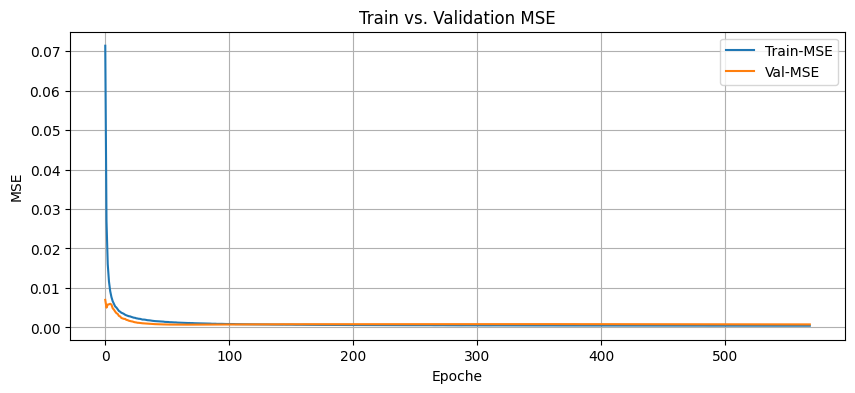

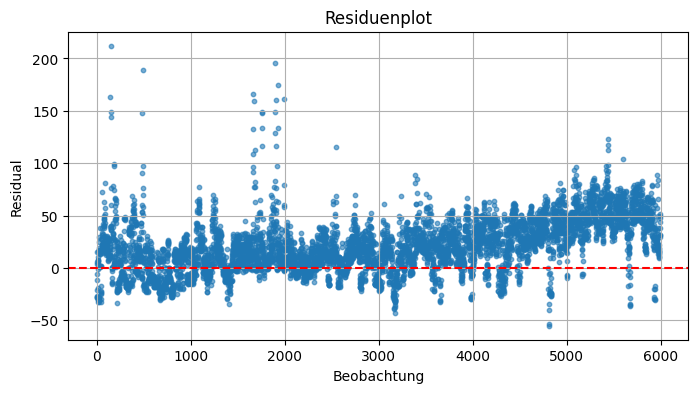

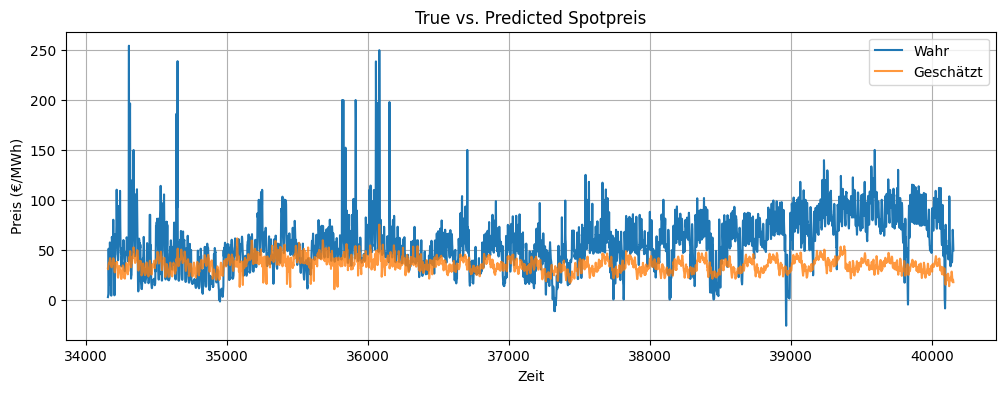

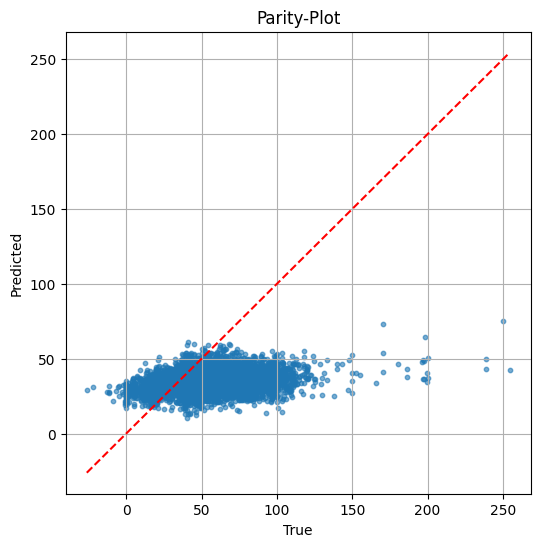

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'].ffill(inplace=True)
df = df["2017-01-01":"2021-07-31 23:00:00"]

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df = df.reset_index()
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7)]:
    df[f'{col}_sin'] = np.sin(2*np.pi*df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi*df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
dk_hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(dk_hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,iv in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=iv[0]) & (df['HourUTC']<=iv[1])).astype(int)

lags = [1,24,168]
for lag in lags:
    df[f'SpotPriceEUR_lag{lag}'] = df['SpotPriceEUR'].shift(lag)
df['SpotPriceEUR_ma24']     = df['SpotPriceEUR'].rolling(24).mean()
df['SpotPriceEUR_ma168']    = df['SpotPriceEUR'].rolling(168).mean()
df['SpotPriceEUR_dev_ma24'] = df['SpotPriceEUR'] - df['SpotPriceEUR_ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_train, i_val = int(0.7*n), int(0.85*n)
df_train = df.iloc[:i_train].copy()
df_val   = df.iloc[i_train:i_val].copy()
df_test  = df.iloc[i_val:].copy()

for d in (df_train, df_val, df_test):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

feat_cols = ['SpotPriceEUR_ma24','SpotPriceEUR_ma168','SpotPriceEUR_dev_ma24'] + \
            [f'SpotPriceEUR_lag{lag}' for lag in lags] + ['temperature_dk']
scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn.pkl")

scaler_y = MinMaxScaler()
df_train['y_scaled'] = scaler_y.fit_transform(df_train[['y_log']])
df_val['y_scaled']   = scaler_y.transform(df_val[['y_log']])
df_test['y_scaled']  = scaler_y.transform(df_test[['y_log']])
joblib.dump(scaler_y, "minmax_scaler_y_ffnn.pkl")

features = ['Monat','Feiertag','corona_dummy','russia_ukraine_dummy',
            'Stunde_sin','Stunde_cos','Wochentag_sin','Wochentag_cos'] + feat_cols

X_train = df_train[features].values
y_train = df_train['y_scaled'].values.reshape(-1,1)
X_val   = df_val[features].values
y_val   = df_val['y_scaled'].values.reshape(-1,1)
X_test  = df_test[features].values
y_test  = df_test['y_scaled'].values.reshape(-1,1)

# ---------------------------------------------------------------------------
# FFNN IN TENSORFLOW/KERAS (ohne Adam)
# ---------------------------------------------------------------------------

n_feat = X_train.shape[1]
model = Sequential([
    Dense(256, activation='relu', input_shape=(n_feat,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64,  activation='relu'),
    Dense(1,   activation='linear')
])

# SGD statt Adam
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss='huber',
    metrics=['mae']
)

class R2Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 10 == 0 or (epoch+1) == self.params['epochs']:
            yv = self.model.predict(X_val, verbose=0)
            yv_orig = np.exp(scaler_y.inverse_transform(yv)) - shift
            yv_true = np.exp(scaler_y.inverse_transform(y_val)) - shift
            r2 = 1 - np.sum((yv_true - yv_orig)**2)/np.sum((yv_true - yv_true.mean())**2)
            print(f" — Val-R² nach Epoche {epoch+1}: {r2:.4f}")

es = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=10000,
    batch_size=32,
    callbacks=[es, R2Callback()],
    verbose=1
)

# ---------------------------------------------------------------------------
# EVALUATION & PLOTS
# ---------------------------------------------------------------------------

y_pred_s = model.predict(X_test)
y_pred_l = scaler_y.inverse_transform(y_pred_s)
y_true_l = scaler_y.inverse_transform(y_test)
y_pred = np.exp(y_pred_l) - shift
y_true = np.exp(y_true_l) - shift

mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train-MSE')
plt.plot(history.history['val_loss'], label='Val-MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuen
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihe
plt.figure(figsize=(12,4))
plt.plot(df_test.index, y_true.flatten(), label="Wahr")
plt.plot(df_test.index, y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()


Epoch     1: Train-MSE=1.340189 | Val-MSE=1.070612 | Val-R²=-19.1396

Early stopping ausgelöst bei Epoche 599.
y_test scaled  min/max: 0.5612470423735948 0.9996686005981116
y_pred_scaled min/max: -0.27776361347477 1.630558335386172
scaler_y min/max       : [0.] [5.72378118]


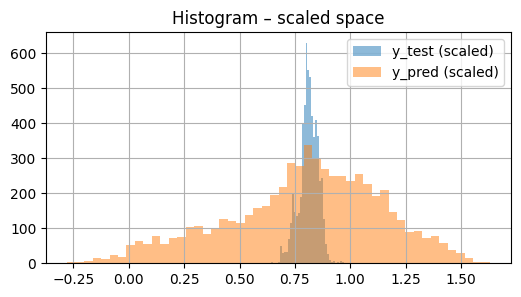

Baseline-MSE (Mittelwert): 688.7

--- Finale Metriken auf dem Test-Set (Originalmaßstab) ---
MSE (€/MWh): 836094.96
MAE (€/MWh): 367.28
R² (Originalmaßstab): -1213.0209


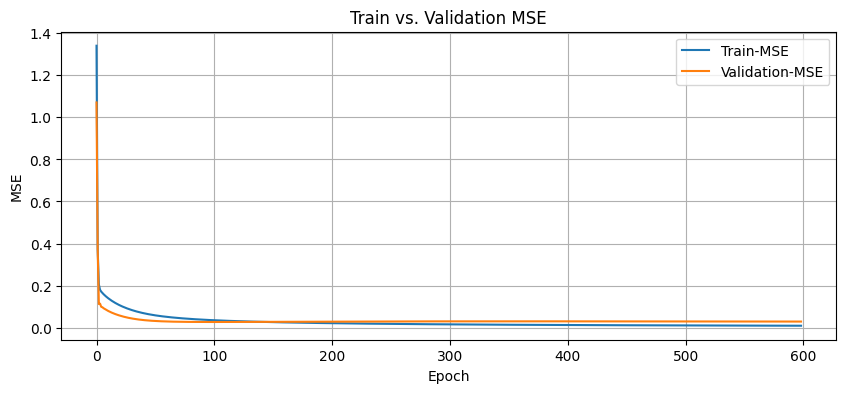

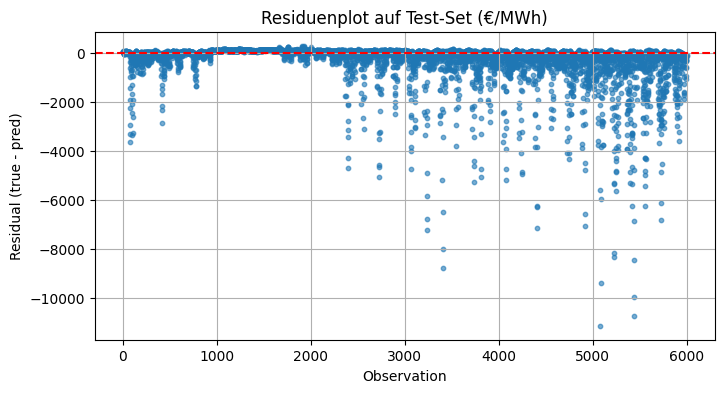

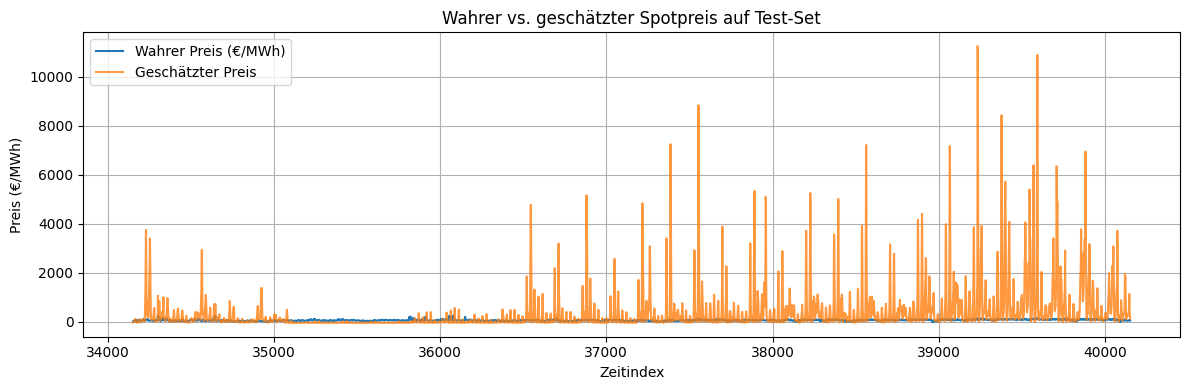

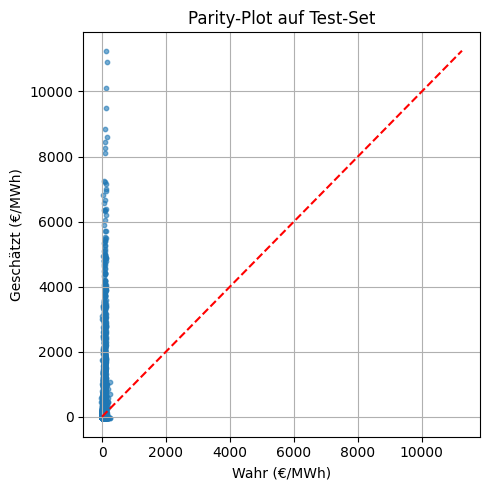

([array([[ 0.50314528, -0.08475633,  0.00422019, ..., -0.12732924,
          -0.17908452,  0.65332647],
         [-0.24304219, -0.05103766, -0.3620448 , ...,  0.32017314,
          -0.007151  ,  0.06895336],
         [ 0.05074553,  0.33292334,  0.0648783 , ..., -0.52351765,
          -0.17582912, -0.01591895],
         ...,
         [ 0.12656124,  0.4028823 , -0.06273491, ...,  0.50087009,
           0.08926238,  0.46283867],
         [-0.17139219, -0.31889722, -0.13937903, ..., -0.40848037,
          -0.02117213,  0.32676573],
         [ 0.32029019,  0.48143723,  0.16570964, ..., -0.28931997,
           0.23158238,  0.36432917]]),
  array([[ 0.05319474, -0.00860258,  0.13678561, ..., -0.03646853,
          -0.08936034,  0.02323636],
         [-0.00975715,  0.09976811,  0.03819507, ...,  0.05473771,
           0.00807931,  0.10899164],
         [ 0.08970354,  0.01942168,  0.1448092 , ..., -0.00943289,
          -0.09278869,  0.03966741],
         ...,
         [ 0.0327441 , -0.00524975

In [ ]:
run_ffnn(X_train, y_train, X_val, y_val, X_test, y_test)

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def run_simulation(seed=42):
    np.random.seed(seed)
    n_steps = 2000
    time = np.arange(n_steps)
    seasonal = 10 * np.sin(2 * np.pi * time / 24)
    noise = np.random.normal(0, 2, size=n_steps)
    y = seasonal + noise

    lags = [1, 24, 72]
    df = pd.DataFrame({'y': y})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df.dropna(inplace=True)

    n = len(df)
    i_tr = int(0.7 * n)
    i_vl = int(0.85 * n)
    df_tr, df_vl, df_te = df.iloc[:i_tr], df.iloc[i_tr:i_vl], df.iloc[i_vl:]

    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    X_tr = scaler_X.fit_transform(df_tr[[f'lag_{lag}' for lag in lags]])
    y_tr = scaler_y.fit_transform(df_tr[['y']]).flatten()
    X_vl = scaler_X.transform(df_vl[[f'lag_{lag}' for lag in lags]])
    y_vl = scaler_y.transform(df_vl[['y']]).flatten()
    X_te = scaler_X.transform(df_te[[f'lag_{lag}' for lag in lags]])
    y_te = scaler_y.transform(df_te[['y']]).flatten()

    # AR(1)
    lr = LinearRegression().fit(df_tr[['lag_1']], df_tr['y'])
    pred_ar1 = lr.predict(df_te[['lag_1']])
    y_true_ar1 = df_te['y'].values

    # FFNN
    def build_ffnn(input_dim):
        model = Sequential([
            InputLayer(input_shape=(input_dim,)),
            Dense(64), LeakyReLU(), Dropout(0.2),
            Dense(32), LeakyReLU(),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    ffnn = build_ffnn(len(lags))
    ffnn.fit(X_tr, y_tr, validation_data=(X_vl, y_vl),
             epochs=50, batch_size=32, verbose=0,
             callbacks=[
                 EarlyStopping('val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau('val_loss', factor=0.5, patience=3)
             ])
    pred_ffnn_s = ffnn.predict(X_te).flatten()
    pred_ffnn = scaler_y.inverse_transform(pred_ffnn_s.reshape(-1,1)).flatten()

    # LSTM
    def build_lstm(seq_len, n_feats):
        model = Sequential([
            tf.keras.Input(shape=(seq_len, n_feats)),
            LSTM(32, return_sequences=False), Dropout(0.2),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    SEQ_LEN = 24
    def make_sequences(X, y, seq_len):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i-seq_len:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_tr_seq, y_tr_seq = make_sequences(X_tr, y_tr, SEQ_LEN)
    X_vl_seq, y_vl_seq = make_sequences(X_vl, y_vl, SEQ_LEN)
    X_te_seq, y_te_seq = make_sequences(X_te, y_te, SEQ_LEN)

    lstm = build_lstm(SEQ_LEN, len(lags))
    lstm.fit(X_tr_seq, y_tr_seq, validation_data=(X_vl_seq, y_vl_seq),
             epochs=50, batch_size=32, verbose=0,
             callbacks=[
                 EarlyStopping('val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau('val_loss', factor=0.5, patience=3)
             ])
    pred_lstm_s = lstm.predict(X_te_seq).flatten()
    y_te_true = scaler_y.inverse_transform(y_te_seq.reshape(-1,1)).flatten()
    pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).flatten()

    y_true_cut = df_te['y'].values[SEQ_LEN:]
    pred_ar1_cut = pred_ar1[SEQ_LEN:]
    pred_ffnn_cut = pred_ffnn[SEQ_LEN:]
    pred_lstm_cut = pred_lstm
    y_lstm_cut = y_te_true

    def evaluate(y_true, y_pred):
        return {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }

    return {
        'AR(1)': evaluate(y_true_cut, pred_ar1_cut),
        'FFNN': evaluate(y_true_cut, pred_ffnn_cut),
        'LSTM': evaluate(y_lstm_cut, pred_lstm_cut)
    }

# Monte-Carlo-Schleife
n_runs = 100
all_results = [run_simulation(seed) for seed in range(n_runs)]

# Ergebnisse aggregieren
flattened = []
for run in all_results:
    row = {}
    for model, metrics in run.items():
        for metric, val in metrics.items():
            row[f'{model}_{metric}'] = val
    flattened.append(row)

df = pd.DataFrame(flattened)
mean_df = df.mean().rename('Mittelwert')
std_df = df.std().rename('Standardabweichung')
summary_df = pd.concat([mean_df, std_df], axis=1)

# Ausgabe
print(summary_df.round(4))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
            Mittelwert  Standardabweichung
AR(1)_MSE      10.7215              0.8236
AR(1)_RMSE      3.2720              0.1248
AR(1)_MAE       2.6317              0.1085
AR(1)_R2        0.8029              0.0140
FFNN_MSE        5.4070              0.4968
FFNN_RMSE       2.3229              0.1067
FFNN_MAE        1.8545              0.0927
FFNN_R2         0.9006              0.0088
LSTM_MSE        4.1369              0.3831
LSTM_RMSE       2.0318              0.0938
LSTM_MAE        1.6226              0.0780
LSTM_R2         0.9239              0.0069


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
            Mittelwert  Standardabweichung
AR(1)_MSE      10.7215              0.8236
AR(1)_RMSE      3.2720              0.1248
AR(1)_MAE       2.6317              0.1085
AR(1)_R2        0.8029              0.0140
FFNN_MSE        5.4094              0.4922
FFNN_RMSE       2.3234              0.1055
FFNN_MAE        1.8562              0.0910
FFNN_R2         0.9005              0.0087
LSTM_MSE        4.1467              0.3887
LSTM_RMSE       2.0342              0.0948
LSTM_MAE        1.6237              0.0794
LSTM_R2         0.9237              0.0070


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


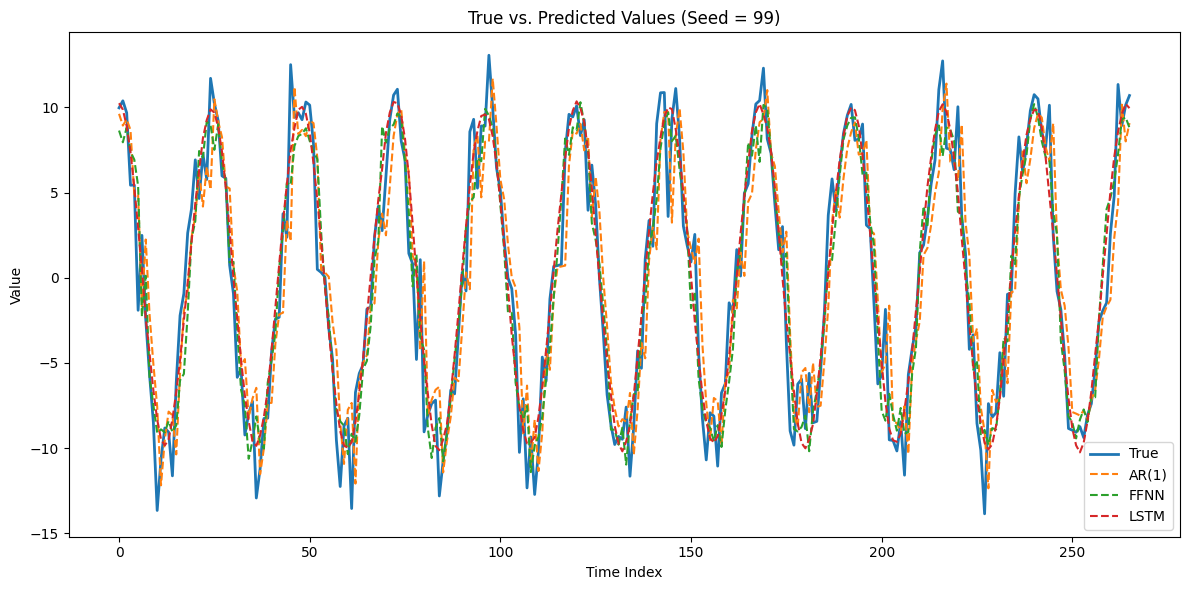

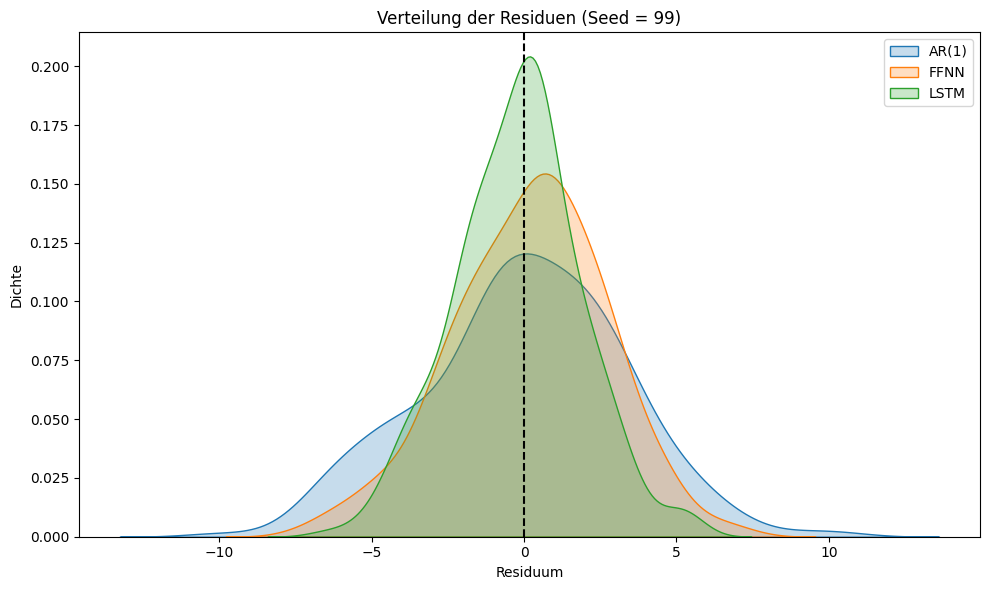

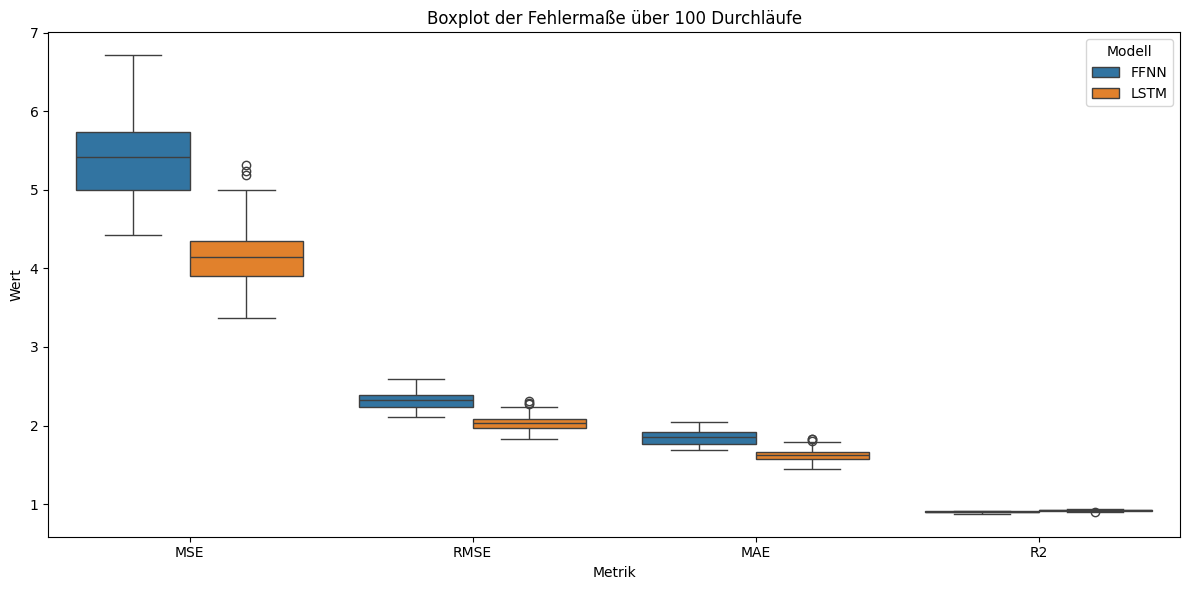

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def run_simulation(seed=42, return_predictions=False):
    np.random.seed(seed)
    n_steps = 2000
    time = np.arange(n_steps)
    seasonal = 10 * np.sin(2 * np.pi * time / 24)
    noise = np.random.normal(0, 2, size=n_steps)
    y = seasonal + noise

    lags = [1, 24, 72]
    df = pd.DataFrame({'y': y})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df.dropna(inplace=True)

    n = len(df)
    i_tr = int(0.7 * n)
    i_vl = int(0.85 * n)
    df_tr, df_vl, df_te = df.iloc[:i_tr], df.iloc[i_tr:i_vl], df.iloc[i_vl:]

    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    X_tr = scaler_X.fit_transform(df_tr[[f'lag_{lag}' for lag in lags]])
    y_tr = scaler_y.fit_transform(df_tr[['y']]).flatten()
    X_vl = scaler_X.transform(df_vl[[f'lag_{lag}' for lag in lags]])
    y_vl = scaler_y.transform(df_vl[['y']]).flatten()
    X_te = scaler_X.transform(df_te[[f'lag_{lag}' for lag in lags]])
    y_te = scaler_y.transform(df_te[['y']]).flatten()

    # AR(1)
    lr = LinearRegression().fit(df_tr[['lag_1']], df_tr['y'])
    pred_ar1 = lr.predict(df_te[['lag_1']])
    y_true_ar1 = df_te['y'].values

    # FFNN
    def build_ffnn(input_dim):
        model = Sequential([
            InputLayer(input_shape=(input_dim,)),
            Dense(64), LeakyReLU(), Dropout(0.2),
            Dense(32), LeakyReLU(),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    ffnn = build_ffnn(len(lags))
    ffnn.fit(X_tr, y_tr, validation_data=(X_vl, y_vl),
             epochs=50, batch_size=32, verbose=0,
             callbacks=[
                 EarlyStopping('val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau('val_loss', factor=0.5, patience=3)
             ])
    pred_ffnn_s = ffnn.predict(X_te).flatten()
    pred_ffnn = scaler_y.inverse_transform(pred_ffnn_s.reshape(-1,1)).flatten()

    # LSTM
    def build_lstm(seq_len, n_feats):
        model = Sequential([
            tf.keras.Input(shape=(seq_len, n_feats)),
            LSTM(32, return_sequences=False), Dropout(0.2),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    SEQ_LEN = 24
    def make_sequences(X, y, seq_len):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i-seq_len:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_tr_seq, y_tr_seq = make_sequences(X_tr, y_tr, SEQ_LEN)
    X_vl_seq, y_vl_seq = make_sequences(X_vl, y_vl, SEQ_LEN)
    X_te_seq, y_te_seq = make_sequences(X_te, y_te, SEQ_LEN)

    lstm = build_lstm(SEQ_LEN, len(lags))
    lstm.fit(X_tr_seq, y_tr_seq, validation_data=(X_vl_seq, y_vl_seq),
             epochs=50, batch_size=32, verbose=0,
             callbacks=[
                 EarlyStopping('val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau('val_loss', factor=0.5, patience=3)
             ])
    pred_lstm_s = lstm.predict(X_te_seq).flatten()
    y_te_true = scaler_y.inverse_transform(y_te_seq.reshape(-1,1)).flatten()
    pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).flatten()

    y_true_cut = df_te['y'].values[SEQ_LEN:]
    pred_ar1_cut = pred_ar1[SEQ_LEN:]
    pred_ffnn_cut = pred_ffnn[SEQ_LEN:]
    pred_lstm_cut = pred_lstm

    def evaluate(y_true, y_pred):
        return {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }

    results = {
        'AR(1)': evaluate(y_true_cut, pred_ar1_cut),
        'FFNN': evaluate(y_true_cut, pred_ffnn_cut),
        'LSTM': evaluate(y_te_true, pred_lstm_cut)
    }

    if return_predictions:
        return results, y_true_cut, pred_ar1_cut, pred_ffnn_cut, pred_lstm_cut
    else:
        return results

# Monte-Carlo-Schleife
n_runs = 100
all_results = [run_simulation(seed) for seed in range(n_runs)]

# Ergebnisse aggregieren
flattened = []
for run in all_results:
    row = {}
    for model, metrics in run.items():
        for metric, val in metrics.items():
            row[f'{model}_{metric}'] = val
    flattened.append(row)

df = pd.DataFrame(flattened)
mean_df = df.mean().rename('Mittelwert')
std_df = df.std().rename('Standardabweichung')
summary_df = pd.concat([mean_df, std_df], axis=1)

# Ausgabe
print(summary_df.round(4))

# Plot: True vs. Predicted für seed=99
_, y_true_cut, pred_ar1_cut, pred_ffnn_cut, pred_lstm_cut = run_simulation(seed=99, return_predictions=True)

plt.figure(figsize=(12, 6))
plt.plot(y_true_cut, label='True', linewidth=2)
plt.plot(pred_ar1_cut, label='AR(1)', linestyle='--')
plt.plot(pred_ffnn_cut, label='FFNN', linestyle='--')
plt.plot(pred_lstm_cut, label='LSTM', linestyle='--')
plt.title('True vs. Predicted Values (Seed = 99)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Verteilung der Residuen
residuals = {
    'AR(1)': y_true_cut - pred_ar1_cut,
    'FFNN': y_true_cut - pred_ffnn_cut,
    'LSTM': y_true_cut - pred_lstm_cut
}

plt.figure(figsize=(10, 6))
for model, res in residuals.items():
    sns.kdeplot(res, label=model, fill=True)
plt.axvline(0, color='black', linestyle='--')
plt.title('Verteilung der Residuen (Seed = 99)')
plt.xlabel('Residuum')
plt.ylabel('Dichte')
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Boxplots aller Metriken
metrics_long = df.melt(var_name='Modell_Metrik', value_name='Wert')
metrics_long[['Modell', 'Metrik']] = metrics_long['Modell_Metrik'].str.extract(r'(\w+)\_(\w+)')

plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_long, x='Metrik', y='Wert', hue='Modell')
plt.title('Boxplot der Fehlermaße über 100 Durchläufe')
plt.tight_layout()
plt.show()


AR(1) Performance auf dem Test-Set:
MSE:  599.06
RMSE: 24.48
MAE:  17.83
R²:   0.1259


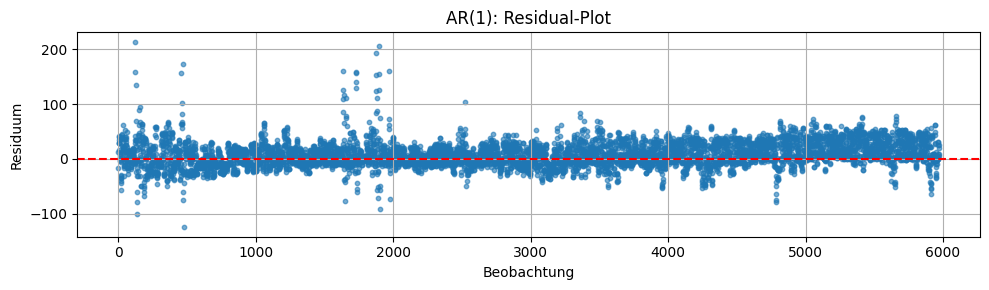

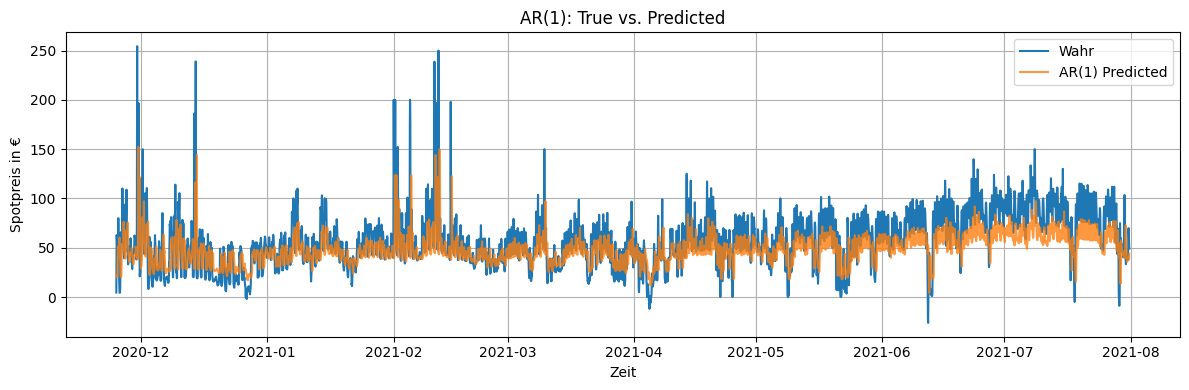

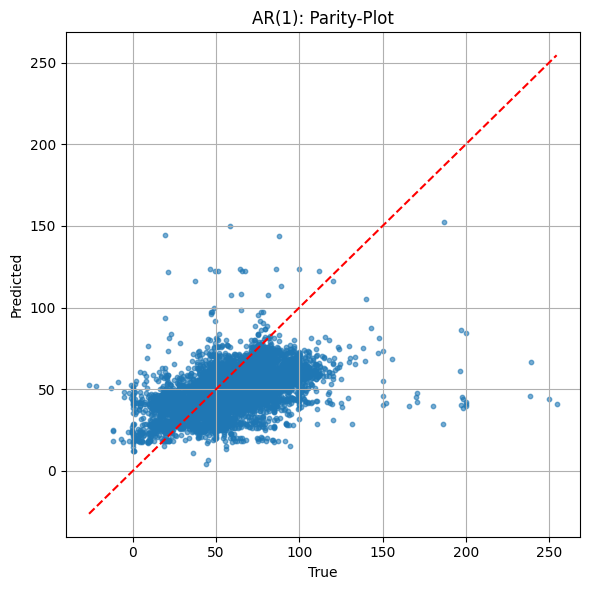

In [7]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (mit Leakage-Fix)
# ---------------------------------------------------------------------------

# Zyklische Zeit-Features
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month
for col, freq in [('Stunde',24), ('Wochentag',7), ('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

# Feiertage
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("Weihnacht1", month=12, day=25),
        Holiday("Weihnacht2", month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

# Krisen-Dummies
intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name, (start, end) in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=start) & (df['HourUTC']<=end)).astype(int)

# Ziel: Spotpreis in +6h
df['SpotPriceEUR_plus6'] = df['SpotPriceEUR'].shift(-6)

# Lags
lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)

# Rolling-Mittelwerte (shifted um 1)
df['ma24']  = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168'] = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

# Entferne jetzt alle Zeilen mit NaN (in lags, rollings, target, ...)
df.dropna(inplace=True)

# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy().set_index('HourUTC')
df_vl = df.iloc[i_tr:i_vl].copy().set_index('HourUTC')
df_te = df.iloc[i_vl:].copy().set_index('HourUTC')

# Shift für Log-Transform auf Basis des Trainingsdatensatzes
shift = -df_tr['SpotPriceEUR_plus6'].min() + 1

for subset in (df_tr, df_vl, df_te):
    subset['y_log'] = np.log(subset['SpotPriceEUR_plus6'] + shift)

# Feature-Liste
feat_cols = [
    'temperature_dk',
    *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
]

# X skalieren
scaler_X = MinMaxScaler()
df_tr[feat_cols] = scaler_X.fit_transform(df_tr[feat_cols])
df_vl[feat_cols] = scaler_X.transform(df_vl[feat_cols])
df_te[feat_cols] = scaler_X.transform(df_te[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn_no_bn.pkl")

# y skalieren
scaler_y = StandardScaler()
df_tr['y_scaled'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_scaled'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_scaled'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_ffnn_no_bn.pkl")

X_train, y_train = df_tr[feat_cols].values, df_tr['y_scaled'].values.reshape(-1,1)
X_val,   y_val   = df_vl[feat_cols].values, df_vl['y_scaled'].values.reshape(-1,1)
X_test,  y_test  = df_te[feat_cols].values, df_te['y_scaled'].values.reshape(-1,1)

# Kurzer NaN-Check
assert not np.isnan(X_train).any(), "X_train enthält noch NaN!"
assert not np.isnan(y_train).any(), "y_train enthält noch NaN!"

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- AR(1) auf das gegebene Dataset ---

# 1. Modell definieren und auf Trainingsdaten fitten
lr_ar1 = LinearRegression()
X_tr_ar1 = df_tr[['lag_1']].values                                # nur Lag-1 als Feature
y_tr_ar1 = df_tr['SpotPriceEUR_plus6'].values                     # ungefiltertes Target
lr_ar1.fit(X_tr_ar1, y_tr_ar1)

# 2. Vorhersage auf Testset
X_te_ar1 = df_te[['lag_1']].values
y_pred_ar1 = lr_ar1.predict(X_te_ar1)
y_true_ar1 = df_te['SpotPriceEUR_plus6'].values

# 3. Performance berechnen
mse_ar1  = mean_squared_error(y_true_ar1, y_pred_ar1)
rmse_ar1 = np.sqrt(mse_ar1)
mae_ar1  = mean_absolute_error(y_true_ar1, y_pred_ar1)
r2_ar1   = r2_score(y_true_ar1, y_pred_ar1)

print("AR(1) Performance auf dem Test-Set:")
print(f"MSE:  {mse_ar1:.2f}")
print(f"RMSE: {rmse_ar1:.2f}")
print(f"MAE:  {mae_ar1:.2f}")
print(f"R²:   {r2_ar1:.4f}")

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Deine AR(1)-Ergebnisse:
# y_true_ar1, y_pred_ar1 und df_te.index

# 1) Residual-Plot
res_ar1 = y_true_ar1 - y_pred_ar1
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(res_ar1)), res_ar1, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Beobachtung')
plt.ylabel('Residuum')
plt.title('AR(1): Residual-Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Zeitreihenplot True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_te.index, y_true_ar1, label='Wahr')
plt.plot(df_te.index, y_pred_ar1, label='AR(1) Predicted', alpha=0.8)
plt.xlabel('Zeit')
plt.ylabel('Spotpreis in €')
plt.title('AR(1): True vs. Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true_ar1, y_pred_ar1, s=10, alpha=0.6)
mn, mx = np.min([y_true_ar1, y_pred_ar1]), np.max([y_true_ar1, y_pred_ar1])
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('AR(1): Parity-Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


AR(1) Performance auf dem Test-Set (log-skaliertes Target):
MSE:  1.5699
RMSE: 1.2530
MAE:  0.9552
R²:   0.1668


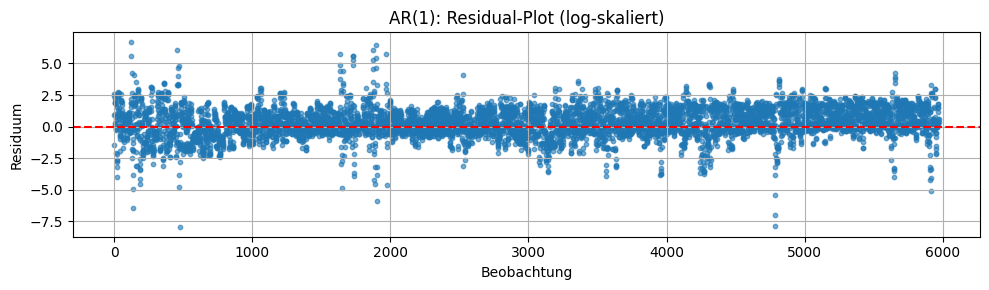

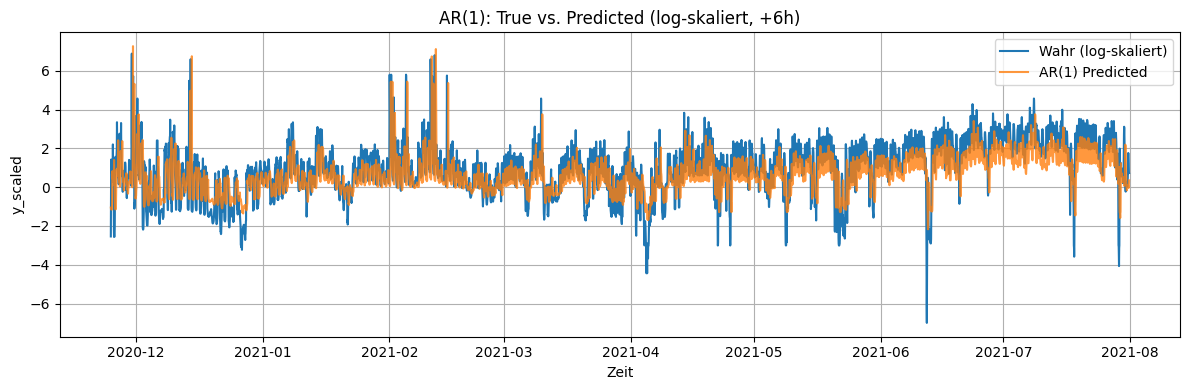

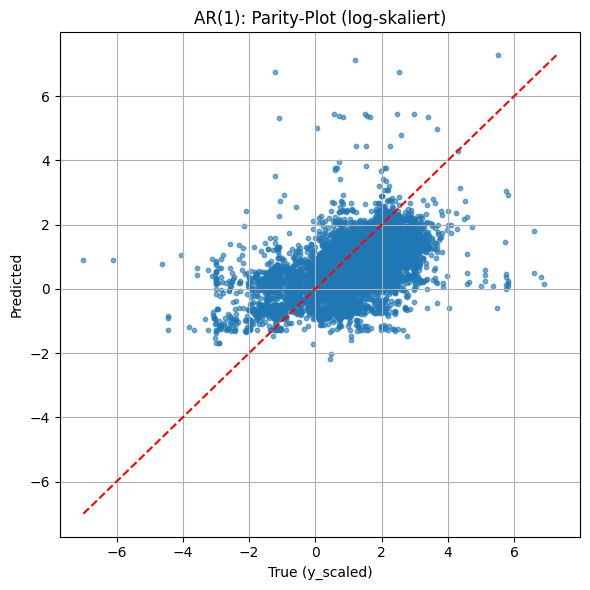

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (mit Leakage-Fix)
# ---------------------------------------------------------------------------

# Zyklische Zeit-Features
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month
for col, freq in [('Stunde',24), ('Wochentag',7), ('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

# Feiertage
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("Weihnacht1", month=12, day=25),
        Holiday("Weihnacht2", month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

# Krisen-Dummies
intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name, (start, end) in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=start) & (df['HourUTC']<=end)).astype(int)

# Ziel: Spotpreis in +6h
df['SpotPriceEUR_plus6'] = df['SpotPriceEUR'].shift(-6)

# Lags
lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)

# Rolling-Mittelwerte (shifted um 1)
df['ma24']  = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168'] = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

# Entferne jetzt alle Zeilen mit NaN (in lags, rollings, target, ...)
df.dropna(inplace=True)

# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy().set_index('HourUTC')
df_vl = df.iloc[i_tr:i_vl].copy().set_index('HourUTC')
df_te = df.iloc[i_vl:].copy().set_index('HourUTC')

# Shift für Log-Transform auf Basis des Trainingsdatensatzes
shift = -df_tr['SpotPriceEUR_plus6'].min() + 1

for subset in (df_tr, df_vl, df_te):
    subset['y_log'] = np.log(subset['SpotPriceEUR_plus6'] + shift)

# Feature-Liste
feat_cols = [
    'temperature_dk',
    *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
]

# X skalieren
scaler_X = MinMaxScaler()
df_tr[feat_cols] = scaler_X.fit_transform(df_tr[feat_cols])
df_vl[feat_cols] = scaler_X.transform(df_vl[feat_cols])
df_te[feat_cols] = scaler_X.transform(df_te[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn_no_bn.pkl")

# y skalieren
scaler_y = StandardScaler()
df_tr['y_scaled'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_scaled'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_scaled'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_ffnn_no_bn.pkl")

X_train, y_train = df_tr[feat_cols].values, df_tr['y_scaled'].values.reshape(-1,1)
X_val,   y_val   = df_vl[feat_cols].values, df_vl['y_scaled'].values.reshape(-1,1)
X_test,  y_test  = df_te[feat_cols].values, df_te['y_scaled'].values.reshape(-1,1)

# Kurzer NaN-Check
assert not np.isnan(X_train).any(), "X_train enthält noch NaN!"
assert not np.isnan(y_train).any(), "y_train enthält noch NaN!"

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- AR(1) auf das gegebene Dataset (FFNN-kompatibel) ---

# 1. Modell definieren und auf Trainingsdaten fitten
lr_ar1 = LinearRegression()
X_tr_ar1 = df_tr[['lag_1']].values                                # nur Lag-1 als Feature
y_tr_ar1 = df_tr['y_scaled'].values                               # log-transformiertes, skaliertes Target
lr_ar1.fit(X_tr_ar1, y_tr_ar1)

# 2. Vorhersage auf Testset
X_te_ar1 = df_te[['lag_1']].values
y_pred_ar1 = lr_ar1.predict(X_te_ar1)
y_true_ar1 = df_te['y_scaled'].values                             # ebenfalls log+skaliert

# 3. Performance berechnen
mse_ar1  = mean_squared_error(y_true_ar1, y_pred_ar1)
rmse_ar1 = np.sqrt(mse_ar1)
mae_ar1  = mean_absolute_error(y_true_ar1, y_pred_ar1)
r2_ar1   = r2_score(y_true_ar1, y_pred_ar1)

print("AR(1) Performance auf dem Test-Set (log-skaliertes Target):")
print(f"MSE:  {mse_ar1:.4f}")
print(f"RMSE: {rmse_ar1:.4f}")
print(f"MAE:  {mae_ar1:.4f}")
print(f"R²:   {r2_ar1:.4f}")

# 1) Residual-Plot
res_ar1 = y_true_ar1 - y_pred_ar1
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(res_ar1)), res_ar1, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Beobachtung')
plt.ylabel('Residuum')
plt.title('AR(1): Residual-Plot (log-skaliert)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Zeitreihenplot True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_te.index, y_true_ar1, label='Wahr (log-skaliert)')
plt.plot(df_te.index, y_pred_ar1, label='AR(1) Predicted', alpha=0.8)
plt.xlabel('Zeit')
plt.ylabel('y_scaled')
plt.title('AR(1): True vs. Predicted (log-skaliert, +6h)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true_ar1, y_pred_ar1, s=10, alpha=0.6)
mn, mx = np.min([y_true_ar1, y_pred_ar1]), np.max([y_true_ar1, y_pred_ar1])
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True (y_scaled)')
plt.ylabel('Predicted')
plt.title('AR(1): Parity-Plot (log-skaliert)')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5596 - mae: 0.5117
Epoch 1: val_loss improved from inf to 0.70075, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.5589 - mae: 0.5112 - val_loss: 0.7007 - val_mae: 0.6226 - learning_rate: 0.0010
Epoch 2/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3041 - mae: 0.3726
Epoch 2: val_loss improved from 0.70075 to 0.57633, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3041 - mae: 0.3725 - val_loss: 0.5763 - val_mae: 0.5632 - learning_rate: 0.0010
Epoch 3/300
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2761 - mae: 0.3462
Epoch 3: val_loss improved from 0.57633 to 0.36182, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2759 - mae: 0.3461 - val_loss: 0.3618 - val_mae: 0.4113 - learning_rate: 0.0010
Epoch 4/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1701 - mae: 0.2786
Epoch 4: val_loss improved from 0.36182 to 0.28128, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1701 - mae: 0.2786 - val_loss: 0.2813 - val_mae: 0.3563 - learning_rate: 0.0010
Epoch 5/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1881 - mae: 0.2660
Epoch 5: val_loss improved from 0.28128 to 0.20825, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1880 - mae: 0.2660 - val_loss: 0.2083 - val_mae: 0.2840 - learning_rate: 0.0010
Epoch 6/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1191 - mae: 0.2249
Epoch 6: val_loss did not improve from 0.20825
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1195 - mae: 0.2250 - val_loss: 0.2330 - val_mae: 0.3411 - learning_rate: 0.0010
Epoch 7/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1133 - mae: 0.2170
Epoch 7: val_loss improved from 0.20825 to 0.18766, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1133 - mae: 0.2170 - val_loss: 0.1877 - val_mae: 0.2750 - learning_rate: 0.0010
Epoch 8/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1085 - mae: 0.2059
Epoch 8: val_loss did not improve from 0.18766
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1086 - mae: 0.2059 - val_loss: 0.2036 - val_mae: 0.3038 - learning_rate: 0.0010
Epoch 9/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1081 - mae: 0.2091
Epoch 9: val_loss improved from 0.18766 to 0.18040, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1082 - mae: 0.2091 - val_loss: 0.1804 - val_mae: 0.2609 - learning_rate: 0.0010
Epoch 10/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0986 - mae: 0.1983
Epoch 10: val_loss did not improve from 0.18040
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0986 - mae: 0.1984 - val_loss: 0.1906 - val_mae: 0.2698 - learning_rate: 0.0010
Epoch 11/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0965 - mae: 0.1932
Epoch 11: val_loss improved from 0.18040 to 0.16611, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0966 - mae: 0.1933 - val_loss: 0.1661 - val_mae: 0.2498 - learning_rate: 0.0010
Epoch 12/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0927 - mae: 0.1874
Epoch 12: val_loss did not improve from 0.16611
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0930 - mae: 0.1875 - val_loss: 0.1770 - val_mae: 0.2661 - learning_rate: 0.0010
Epoch 13/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1211 - mae: 0.2068
Epoch 13: val_loss did not improve from 0.16611
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1209 - mae: 0.2067 - val_loss: 0.2006 - val_mae: 0.3061 - learning_rate: 0.0010
Epoch 14/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0972 - mae: 0.1929
Epoch 14: val_loss did not improve from 0.16611
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0972 - mae: 0.1929 - val_loss: 0.3080 - val_mae: 0.4339 - learning_rate: 0.0010
Epoch 15/300
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1066 - mae: 0.2021


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1067 - mae: 0.2021 - val_loss: 0.1571 - val_mae: 0.2384 - learning_rate: 0.0010
Epoch 16/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1194 - mae: 0.1965
Epoch 16: val_loss did not improve from 0.15708
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1194 - mae: 0.1965 - val_loss: 0.1632 - val_mae: 0.2486 - learning_rate: 0.0010
Epoch 17/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1098 - mae: 0.1984
Epoch 17: val_loss did not improve from 0.15708
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1098 - mae: 0.1984 - val_loss: 0.1598 - val_mae: 0.2419 - learning_rate: 0.0010
Epoch 18/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1088 - mae: 0.2022
Epoch 18: val_loss did not improve from 0.15708
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1087 - mae: 0.2022 - val_loss: 0.1821 - val_mae: 0.2713 - learning_rate: 0.0010
Epoch 19/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0985 - mae: 0.1895


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0985 - mae: 0.1895 - val_loss: 0.1565 - val_mae: 0.2368 - learning_rate: 0.0010
Epoch 20/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0978 - mae: 0.1911
Epoch 20: val_loss did not improve from 0.15648
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0979 - mae: 0.1911 - val_loss: 0.1795 - val_mae: 0.2728 - learning_rate: 0.0010
Epoch 21/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1056 - mae: 0.1972
Epoch 21: val_loss did not improve from 0.15648
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1056 - mae: 0.1972 - val_loss: 0.1813 - val_mae: 0.2770 - learning_rate: 0.0010
Epoch 22/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0967 - mae: 0.1853
Epoch 22: val_loss did not improve from 0.15648
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0967 - mae: 0.1853 - val_loss: 0.1729 - val_mae: 0.2653 - learning_rate: 0.0010
Epoch 23/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0901 - mae: 0.1842


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0936 - mae: 0.1851 - val_loss: 0.1504 - val_mae: 0.2288 - learning_rate: 0.0010
Epoch 29/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0969 - mae: 0.1828
Epoch 29: val_loss did not improve from 0.15036
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0968 - mae: 0.1828 - val_loss: 0.1772 - val_mae: 0.2788 - learning_rate: 0.0010
Epoch 30/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0800 - mae: 0.1792
Epoch 30: val_loss did not improve from 0.15036
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0801 - mae: 0.1792 - val_loss: 0.1614 - val_mae: 0.2442 - learning_rate: 0.0010
Epoch 31/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0879 - mae: 0.1802
Epoch 31: val_loss did not improve from 0.15036
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0879 - mae: 0.1802 - val_loss: 0.1524 - val_mae: 0.2437 - learning_rate: 0.0010
Epoch 32/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0806 - mae: 0.1762


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0931 - mae: 0.1831 - val_loss: 0.1502 - val_mae: 0.2317 - learning_rate: 0.0010
Epoch 42/300
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0768 - mae: 0.1714
Epoch 42: val_loss did not improve from 0.15017
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0769 - mae: 0.1715 - val_loss: 0.1631 - val_mae: 0.2582 - learning_rate: 0.0010
Epoch 43/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0778 - mae: 0.1721
Epoch 43: val_loss did not improve from 0.15017
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0778 - mae: 0.1721 - val_loss: 0.1674 - val_mae: 0.2621 - learning_rate: 0.0010
Epoch 44/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0812 - mae: 0.1742
Epoch 44: val_loss did not improve from 0.15017
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0813 - mae: 0.1742 - val_loss: 0.1541 - val_mae: 0.2434 - learning_rate: 0.0010
Epoch 45/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0805 - mae: 0.1727


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0807 - mae: 0.1816 - val_loss: 0.1441 - val_mae: 0.2320 - learning_rate: 0.0010
Epoch 48/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0770 - mae: 0.1719
Epoch 48: val_loss did not improve from 0.14411
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0771 - mae: 0.1720 - val_loss: 0.1823 - val_mae: 0.2763 - learning_rate: 0.0010
Epoch 49/300
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784 - mae: 0.1713
Epoch 49: val_loss did not improve from 0.14411
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0785 - mae: 0.1713 - val_loss: 0.3221 - val_mae: 0.3951 - learning_rate: 0.0010
Epoch 50/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1148 - mae: 0.1970
Epoch 50: val_loss did not improve from 0.14411
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1147 - mae: 0.1969 - val_loss: 0.1693 - val_mae: 0.2441 - learning_rate: 0.0010
Epoch 51/300
430/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0791 - mae: 0.1716


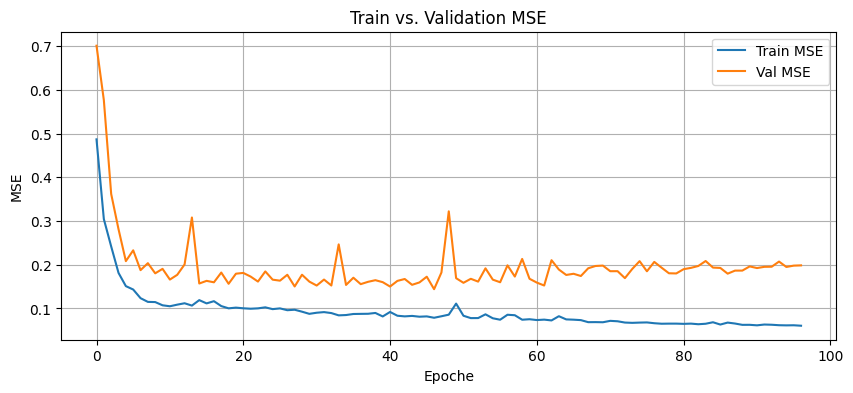

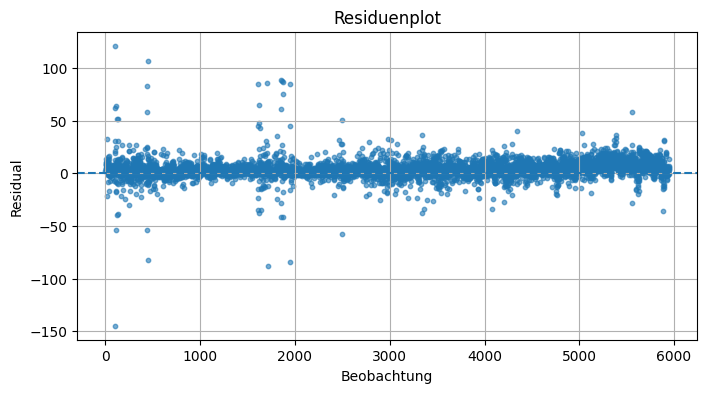

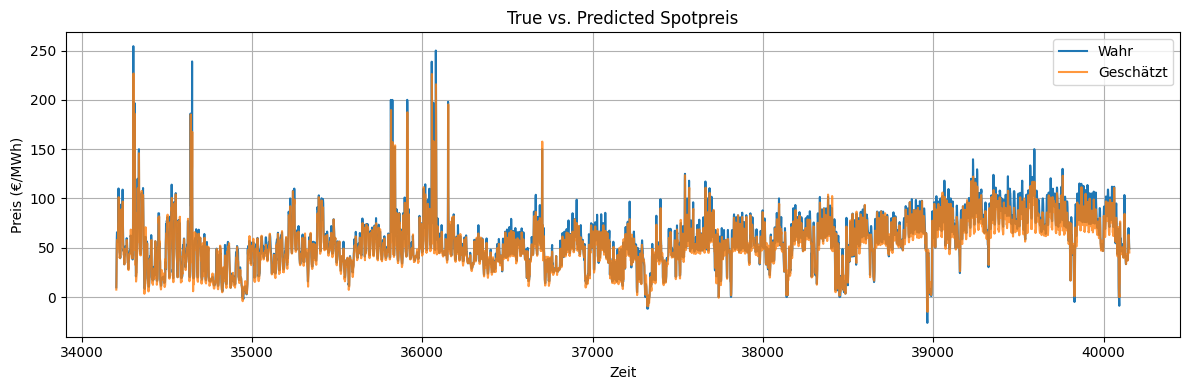

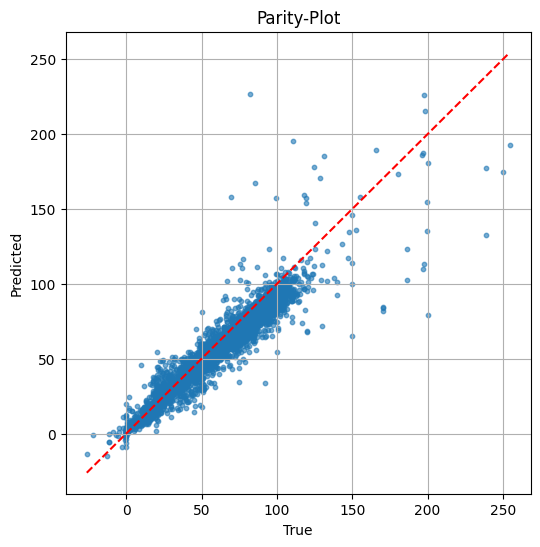

In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN & PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (Leakage-Fix)
# ---------------------------------------------------------------------------

df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7),('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,(s,e) in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=s)&(df['HourUTC']<=e)).astype(int)

# Lags und Rolling-Features
lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)
df['ma24']     = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168']    = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy()
df_vl = df.iloc[i_tr:i_vl].copy()
df_te = df.iloc[i_vl:].copy()

for d in (df_tr, df_vl, df_te):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

scaler_y = StandardScaler()
df_tr['y_s'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_s'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_s'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_lstm.pkl")

feat_cols = [
    'temperature_dk',
    *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
]
scaler_X = MinMaxScaler()
df_tr[feat_cols] = scaler_X.fit_transform(df_tr[feat_cols])
df_vl[feat_cols] = scaler_X.transform(df_vl[feat_cols])
df_te[feat_cols] = scaler_X.transform(df_te[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_lstm.pkl")

# Sequenzen für LSTM
def make_seq(df, seq_len=24):
    X,y = [],[]
    arr = df[feat_cols+['y_s']].values
    for i in range(seq_len,len(arr)):
        X.append(arr[i-seq_len:i,:-1])
        y.append(arr[i,-1])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X_tr, y_tr = make_seq(df_tr, SEQ_LEN)
X_vl, y_vl = make_seq(df_vl, SEQ_LEN)
X_te, y_te = make_seq(df_te, SEQ_LEN)

# ---------------------------------------------------------------------------
# 4. LSTM-MODELL (ohne BatchNormalization)
# ---------------------------------------------------------------------------

n_feats = X_tr.shape[2]
model = Sequential([
    Input(shape=(SEQ_LEN, n_feats)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

cbs = [
    EarlyStopping('val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_lstm.h5", 'val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs/lstm", histogram_freq=1),
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_vl, y_vl),
    epochs=300,
    batch_size=64,
    callbacks=cbs,
    verbose=1
)

# ---------------------------------------------------------------------------
# 5. EVALUATION & PLOTS
# ---------------------------------------------------------------------------

y_pred_s = model.predict(X_te)
y_pred_l = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
y_true_l = scaler_y.inverse_transform(y_te.reshape(-1,1))

y_pred = np.exp(y_pred_l) - shift
y_true = np.exp(y_true_l) - shift

mse = np.mean((y_true-y_pred)**2)
mae = np.mean(np.abs(y_true-y_pred))
r2  = 1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# (Plots unverändert…)



# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihe True vs. Predicted
# Korrigierter Zeitindex: ab SEQ_LEN, damit er zur Länge von y_true/y_pred passt
index_seq = df_te.index[SEQ_LEN:]

# Plot: Wahre vs. geschätzte Werte
plt.figure(figsize=(12,4))
plt.plot(index_seq, y_true.flatten(), label="Wahr")
plt.plot(index_seq, y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit")
plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()